**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Aprendizaje Automático**

**Segundo Semestre 2025**

**Profesor:** Dr. Luis-Alexander Calvo-Valverde

---

**Trabajo Práctico:** 2

**Datos de la entrega:** Jueves 23 de octubre 2025, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter (`.ipynb`) y todos los archivos adicionales que se requieran para correr su cuaderno (en un archivo comprimido).

---

**Estudiantes:**
- David Alberto Guevara Sánchez
- Kenneth Barboza Corrales

# Nota Introductoria.

Usted puede cambiar los datasets que se le proporcionan por otros de su interés; pero de hacerlo, se le recomienda valorarlo con el profesor para que sus datasets no le agreguen una complicación importante al Trabajo Práctico.

___

# Parte 1 - Regresión (50 puntos)

___

# Introducción

Considere:
- Se le proporciona un conjunto de datos (diamonds), si desea conocer un poco de los atributos puede consultar en: <https://www.kaggle.com/datasets/shivam2503/diamonds>
- Note que en la página proporcionada se mencionan más atributos de los que contiene el archivo facilitado.
- El objetivo de esta parte es ver como el estudiante se enfrenta al proceso de pre-procesamiento, selección de atributos, predicción y evaluación. Por eso es muy importante que documente en este cuaderno sus decisiones, eso se tomará muy en cuenta en la evaluación de su respuesta.
- El atributo a predecir en regresión se denomina: price.
- Debe comentar ampliamente su código

In [150]:
from __future__ import annotations

import math
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dython.nominal import associations
from IPython.display import display
from pandas import DataFrame, Series
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

sns.set_theme(style="whitegrid")
set_config(transform_output="pandas")

### 1 (5 puntos)
- Cargue el archivo.
- Utilice las herramientas (gráficos, funciones que describen contenido o características de las variables, etc) que considere necesarias para analizar los atributos que tiene el dataset y ver si tiene valores faltantes, valores atípicos, etc.
- Comente sus conclusiones sobre los atributos.

---

En el siguiente bloque de código leemos el archivo `diamonds.csv` como un `DataFrame` de nombre `df`. Adicionalmente, convertimos la variable `cut` a tipo categórico para facilitar su análisis.

In [151]:
df = pd.read_csv("./data/diamonds.csv")
df["cut"] = df["cut"].astype("category")

**Nota:** en el archivo original la variable `cut` está codificada con valores enteros del 0 al 4. Al convertirla en categórica mantenemos esa codificación, pero conservamos un listado de etiquetas descriptivas para emplearlas en los gráficos. También utilizamos una variable `column_labels` para mapear los nombres de las columnas a etiquetas más descriptivas.

In [152]:
cut_labels = ["Regular", "Bueno", "Muy bueno", "Premium", "Ideal"]
cut_order = df["cut"].cat.categories.tolist()

column_labels = {
    "carat": "Quilates (carat)",
    "depth": "Profundidad (%)",
    "table": "Tabla (%)",
    "x": "Largo (mm)",
    "y": "Ancho (mm)",
    "z": "Altura (mm)",
    "price": "Precio (USD)",
    "cut": "Tipo de corte",
}

Con el siguiente bloque de código podemos observar que el `DataFrame` tiene 53940 filas, ninguna de las cuales contiene valores nulos.

In [153]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   carat   53940 non-null  float64 
 1   depth   53940 non-null  float64 
 2   table   53940 non-null  float64 
 3   price   53940 non-null  int64   
 4   x       53940 non-null  float64 
 5   y       53940 non-null  float64 
 6   z       53940 non-null  float64 
 7   cut     53940 non-null  category
dtypes: category(1), float64(6), int64(1)
memory usage: 2.9 MB


Con el siguiente bloque de código podemos observar las primeras 5 filas del `DataFrame`.

In [154]:
df.head(5)

,carat,depth,table,price,x,y,z,cut
0,0.23,61.5,55.0,326,3.95,3.98,2.43,4
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1


#### Mapa de correlaciones

El primer gráfico que vamos a generar es uno para observar la correlación entre los atributos del `DataFrame`.

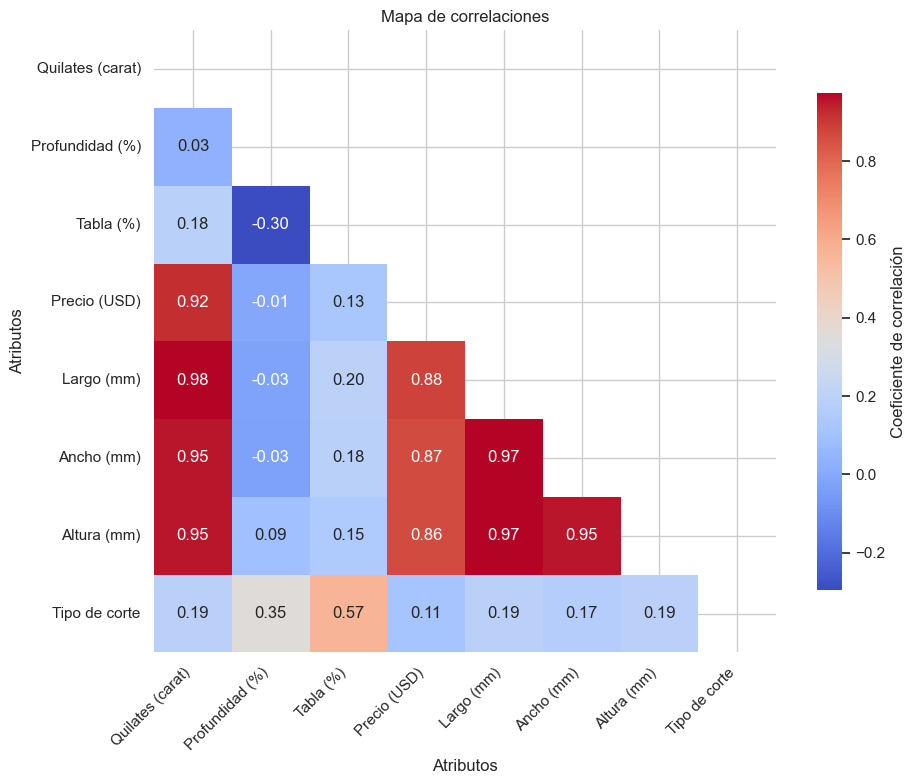

In [155]:
association_results = associations(df, nominal_columns=["cut"], plot=False)

corr = association_results["corr"]
label_map = {col: column_labels.get(col, col) for col in corr.columns}
corr = corr.rename(index=label_map, columns=label_map)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"label": "Coeficiente de correlación", "shrink": 0.8},
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Mapa de correlaciones")
plt.xlabel("Atributos")
plt.ylabel("Atributos")
plt.tight_layout()
plt.show()

Este mapa de asociaciones generado con `dython` confirma que los atributos `x`, `y` y `z` (las dimensiones del diamante) están altamente correlacionados entre sí y con `carat`: los coeficientes alcanzan valores de 0.98 entre `carat` y `x`, 0.95 con `y`, 0.95 con `z`, y superan 0.86 cuando se comparan las dimensiones con `price`. Asimismo, `carat` mantiene una correlación de 0.92 con el precio. Este comportamiento es consistente con la naturaleza del material, pues las dimensiones y el peso avanzan casi en bloque.

Por otra parte, observamos que `table` y `depth` conservan relaciones más débiles con `price` (0.13 y −0.01, respectivamente), mientras que el tipo de corte muestra asociaciones moderadas con `table` (0.57) y `depth` (0.35) pero solo leves con el resto de variables (≈0.19 con `carat`, `x` y `z`, y 0.11 con `price`). Estos patrones respaldan la idea de reducir `x`, `y` y `z` para evitar colinealidad sin perder información relevante, a la vez que justifican mantener `table` y `cut` como fuentes de variación complementaria.

Debido a esta alta correlación podríamos considerar unificar los atributos `x`, `y` y `z` en una sola variable `volume` (el volumen del diamante), o incluso descartarlos, ya que estos están altamente relacionados con `carat`, por lo que no temeríamos perder información al hacerlo.

En contraste, atributos como `depth`, `table` y `cut` muestran vínculos más modestos con el precio; no obstante, aportan señales complementarias (por ejemplo, la asociación de `cut` con `table`) que conviene explorar antes de eliminarlos por completo.

#### Diagramas de dispersión

A continuación generamos diagramas de dispersión de las variables numéricas comparadas con `price`, la cual es la variable que deseamos predecir. Esto con el fin de analizar si existe una tendencia lineal entre los datos correlacionados y revisar el comportamiento de los datos con relación más baja.


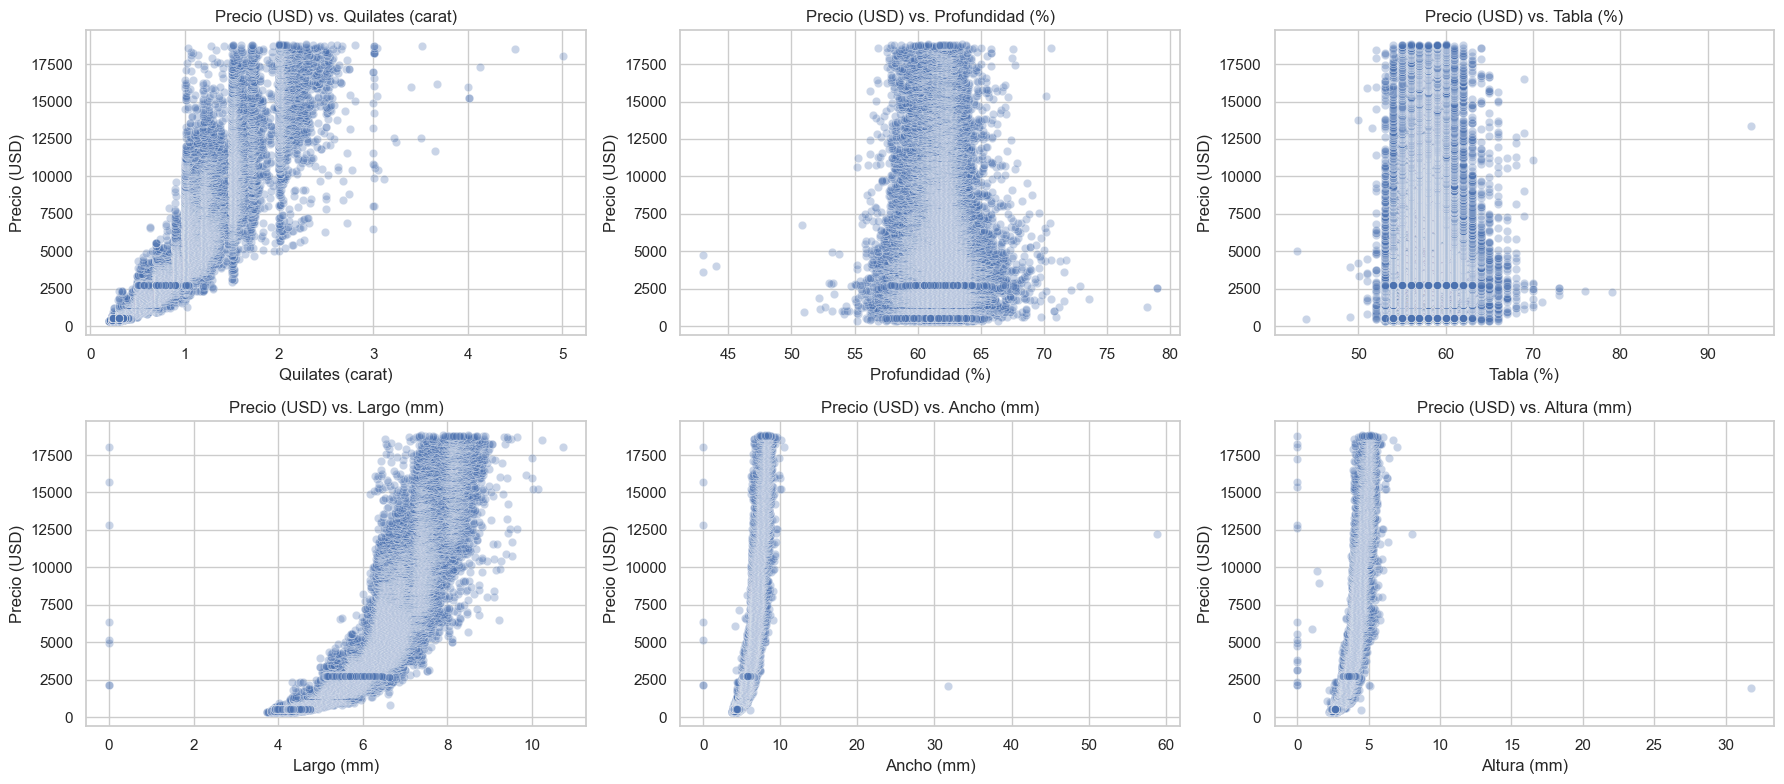

In [156]:
num_cols = df.select_dtypes(include="number").columns.drop("price")
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.scatterplot(x=col, y="price", data=df, alpha=0.3, ax=ax)
    ax.set_title(f"Precio (USD) vs. {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel(column_labels["price"])
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
plt.tight_layout()
plt.show()

De estos gráficos se puede apreciar lo siguiente:
- `carat` presenta una correlación positiva con respecto a `price`. Tiende a dispersarse mucho en los precios más altos y se llega a un pico de aumento. Este es un buen punto para escalar los datos de `price` para rectificar la curva y aclarar la varianza.
- `x`, `y` y `z` presentan correlaciones positivas afectadas por posibles outliers y valores extraños como el 0 en sus dimensiones. Idealmente se deberían descartar esos valores.
- `table` y `depth`, como vimos anteriormente, mantienen una relación débil con `price` (tendencia poco clara), mientras que `cut` actúa como un predictor adicional con asociaciones moderadas hacia `table` y leves hacia el precio.

#### Diagramas de cajas

A continuación se muestra un diagrama de cajas de `price` contra `cut`, que es una variable categórica.

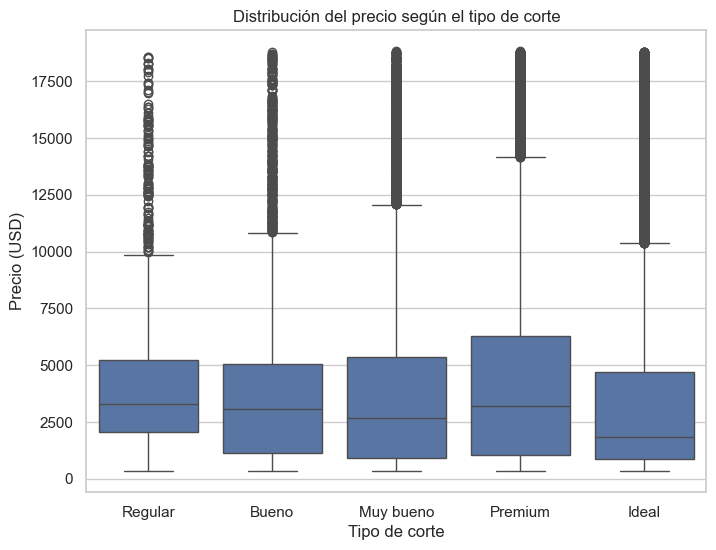

In [157]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="cut",
    y="price",
    data=df,
    order=cut_order,
)
plt.title("Distribución del precio según el tipo de corte")
plt.xlabel("Tipo de corte")
plt.ylabel(column_labels["price"])
plt.xticks(range(len(cut_order)), [cut_labels[int(cat)] for cat in cut_order])
plt.show()

El tipo de corte (la variable `cut`) influye muy poco en el precio y parece que solo introduce valores atípicos, ya que hay muchos diamantes con precios mayores de lo que se esperaría. No es el predictor más fuerte, pero puede que influya como valor categórico.

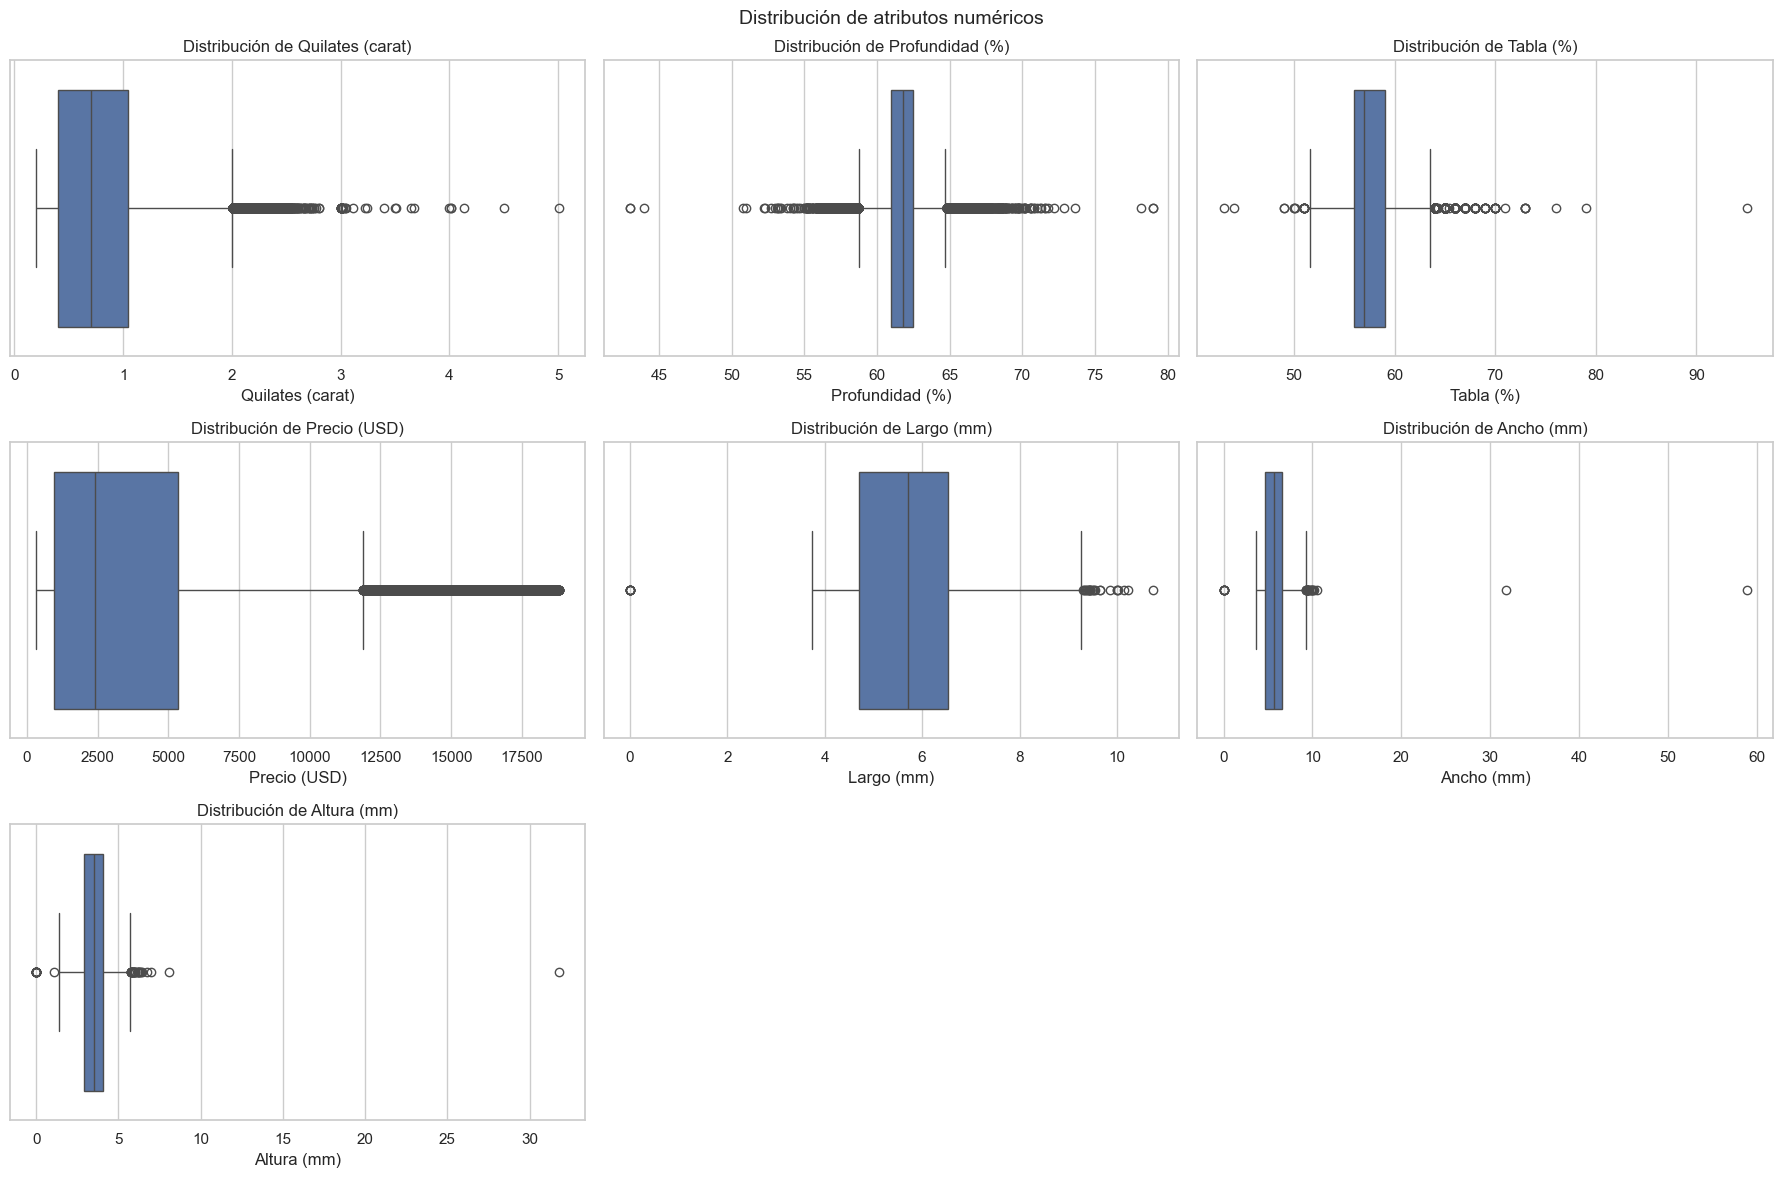

In [158]:
num_cols = df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.boxplot(x=col, data=df, ax=ax, orient="h")
    ax.set_title(f"Distribución de {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel("")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos numéricos", fontsize=14)
fig.tight_layout()
plt.show()

En estos diagramas de cajas puede apreciar que:
- `price` y `carat` presentan colas largas hacia la derecha. La mayor parte de los diamantes es barata y hay una cola de diamantes caros. Esto implica que muchos de los outliers por IQR no son errores, sino la realidad del mercado.
- `depth` y `table` están bastante concentrados cerca de 60, con algunos outliers a ambos lados, los cuales son posibles pero hay que tratar con cautela.
- `x`, `y` y `z` muestran valores imposibles (cercanos a 0) y extremos gigantes. Estos podrían ser posibles errores y deben filtrarse.

#### Histogramas

Finalmente revisamos el comportamiento de las variables mediante el uso de histogramas:

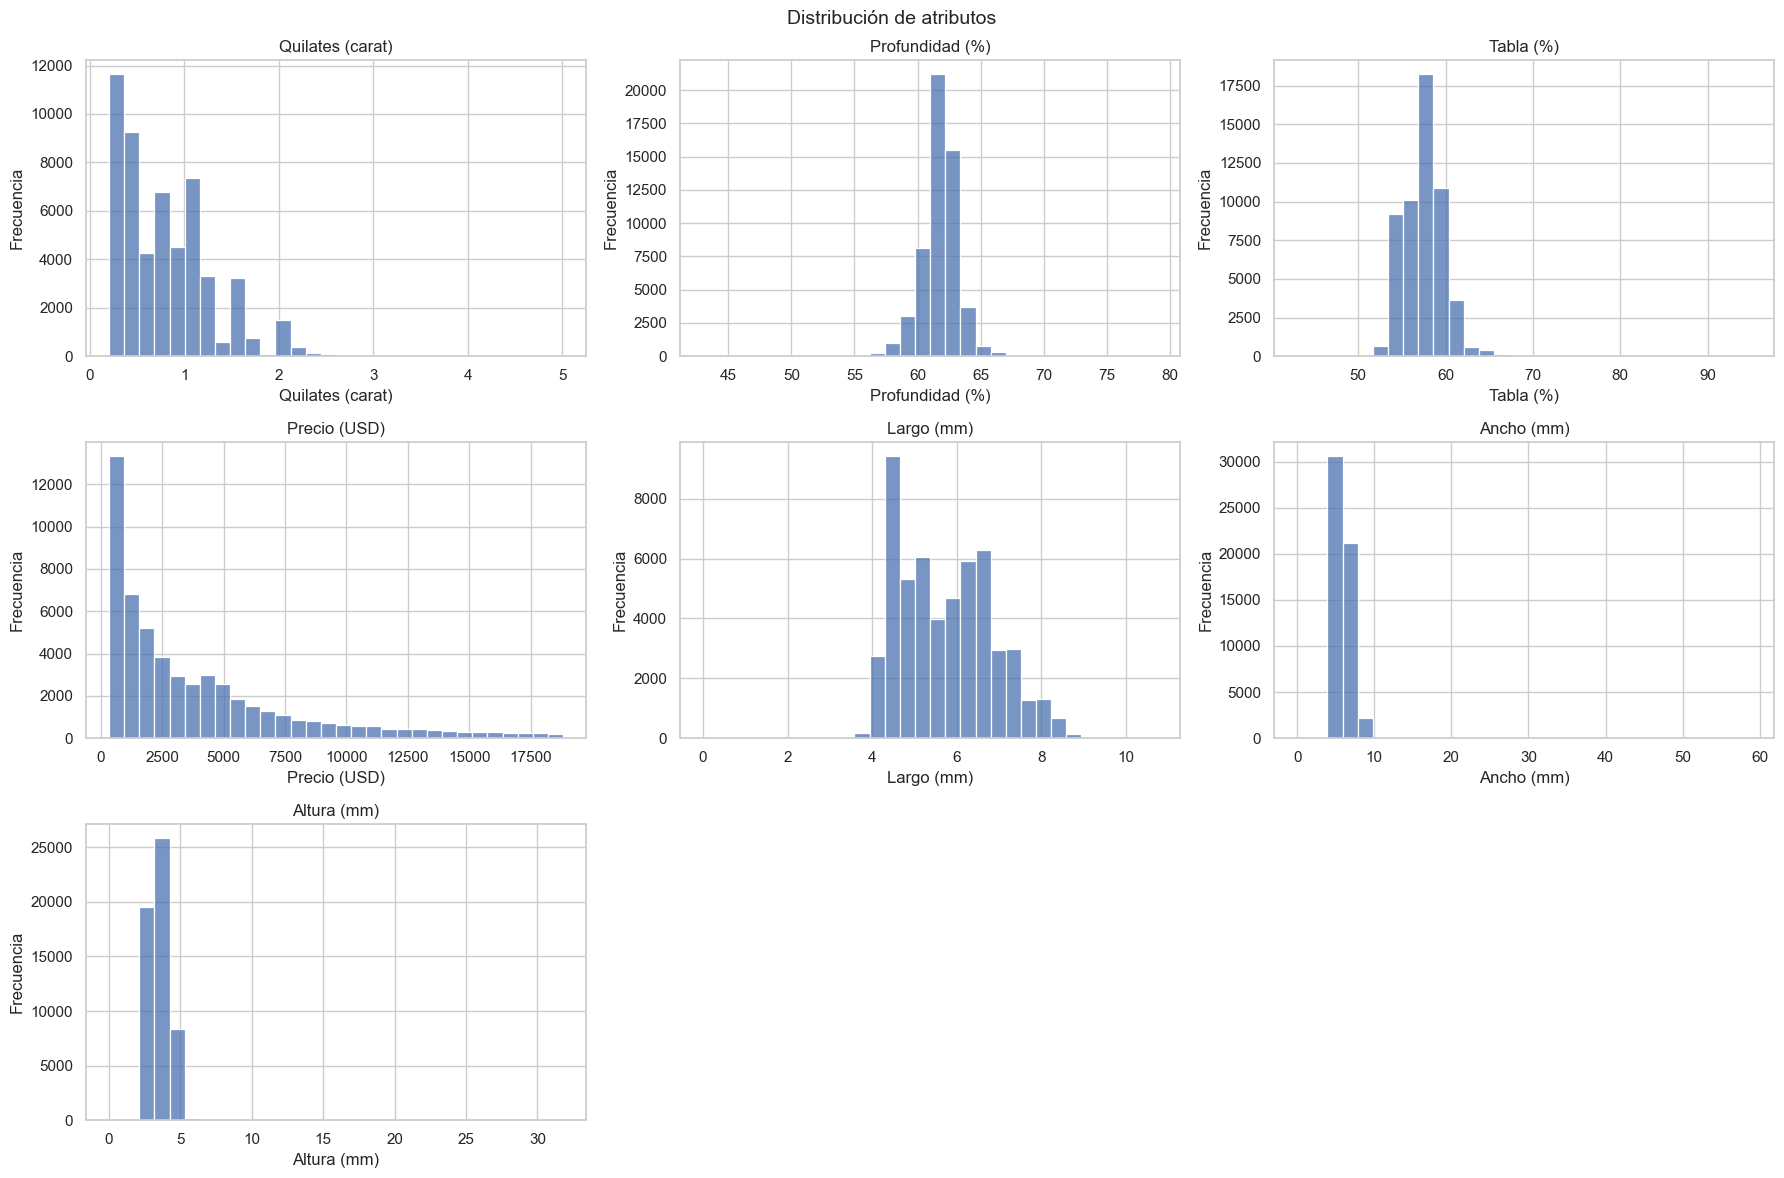

In [159]:
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos", fontsize=14)
fig.tight_layout()
plt.show()

Estos histogramas confirman nuestras observaciones anteriores.

### 2 (5 puntos)
- Se utilizará el modelo Train/Validation (70%) y Test (30%).
- Comente su decisión sobre los parámetros shuffle y random_state
- Separe los conjuntos de datos (70-30) (X_trainVal, X_test, y_trainVal, y_test )
- Muestre los primeros 5 registros de cada conjunto.

---

Para los parámetros mencionados se tomaron las siguientes decisiones:
- `shuffle`: el `DataFrame` no tiene una dependencia en el orden de sus datos y, como los datos más determinantes para la predicción tienden a valores más bajos, es beneficioso barajar las filas para evitar que el `train` o `test` solo contengan estos valores, es decir, para que haya una mejor distribución.
- `random_state`: debido a la naturaleza del trabajo práctico se desea tener reproducibilidad en las ejecuciones, especialmente porque se está trabajando en grupo. Debido a esto definir el valor del `random_state` es necesario para asegurar que la división sea la misma en varias ejecuciones, se escogió el número 42 por ser uno de los más comunes en ejemplos de regresión.

In [160]:
x = df.drop("price", axis=1)
y = df["price"]

x_train_raw, x_test_raw, y_train_raw, y_test_raw = cast(
    tuple[DataFrame, DataFrame, Series, Series],
    train_test_split(x, y, test_size=0.30, random_state=42, shuffle=True),
)

In [161]:
display(x_train_raw.head(5))
display(x_test_raw.head(5))
display(y_train_raw.head(5))
display(y_test_raw.head(5))

,carat,depth,table,x,y,z,cut
19497,1.21,61.3,57.0,6.92,6.87,4.23,4
31229,0.31,62.0,56.0,4.38,4.36,2.71,4
22311,1.21,62.4,57.0,6.75,6.83,4.24,4
278,0.81,62.6,55.0,5.92,5.96,3.72,4
6646,0.79,61.7,56.0,5.94,5.95,3.67,4


,carat,depth,table,x,y,z,cut
1388,0.24,62.1,56.0,3.97,4.00,2.47,4
50052,0.58,60.0,57.0,5.44,5.42,3.26,2
41645,0.40,62.1,55.0,4.76,4.74,2.95,4
42377,0.43,60.8,57.0,4.92,4.89,2.98,3
17244,1.55,62.3,55.0,7.44,7.37,4.61,4


19497     8131
31229      756
22311    10351
278       2795
6646      4092
Name: price, dtype: int64

1388      559
50052    2201
41645    1238
42377    1304
17244    6901
Name: price, dtype: int64

### 3 (10 puntos)
- Preprocese los atributos (Solo deje para más adelante escalar los datos).
- Debe comentar en celdas del texto el por qué seleccionó las técnicas utilizadas.

---

Primero mostremos la cantidad de datos que hay en cada conjunto antes de remover datos duplicados, outliers y datos inválidos.

In [162]:
print(f"""
El conjunto de entrenamiento tiene {len(x_train_raw)} filas.
El conjunto de prueba tiene {len(x_test_raw)} filas.
""")


El conjunto de entrenamiento tiene 37758 filas.
El conjunto de prueba tiene 16182 filas.



#### Eliminación de datos duplicados

Al eliminar filas duplicadas se mejora la integridad del modelo y se evita sobrerepresentar ciertas observaciones, esto puede servir en el caso de diamantes ya que la predicción puede ser afectada por el precio de mercado especialmente en los valores de `carat` bajos.

In [163]:
x_train_no_dups = x_train_raw.drop_duplicates()
x_test_no_dups = x_test_raw.drop_duplicates()

y_train_no_dups = y_train_raw.loc[x_train_no_dups.index]
y_test_no_dups = y_test_raw.loc[x_test_no_dups.index]

#### Remoción de outliers y datos inválidos

Estos datos como $x,y,z = 0$ o dimensiones no realistas pueden afectar al modelo e introducir ruido, por lo que se decidió filtrarlos. También se decidió filtrar los valores fuera del rango intercuartílico (IQR) para las dimensiones `x`, `y` y `z`, ya que estos pueden ser _outliers_.

In [164]:
xyz_cols = ["x", "y", "z"]
xyz_quartiles = x_train_no_dups[xyz_cols].quantile([0.25, 0.75])
xyz_iqr = xyz_quartiles.loc[0.75] - xyz_quartiles.loc[0.25]
xyz_bounds = pd.DataFrame(
    {
        "lower": xyz_quartiles.loc[0.25] - 1.5 * xyz_iqr,
        "upper": xyz_quartiles.loc[0.75] + 1.5 * xyz_iqr,
    }
)


def quality_filter(df: DataFrame, bounds: DataFrame) -> Series:
    base_mask = (
        (df["carat"] > 0)
        & (df["x"] > 0)
        & (df["y"] > 0)
        & (df["z"] > 0)
        & (df["depth"].between(40, 80))
        & (df["table"].between(40, 80))
    )
    xyz_mask = (df[xyz_cols].ge(bounds["lower"]) & df[xyz_cols].le(bounds["upper"])).all(axis=1)
    return base_mask & xyz_mask


train_quality_mask = quality_filter(x_train_no_dups, xyz_bounds)
test_quality_mask = quality_filter(x_test_no_dups, xyz_bounds)

x_train_filtered = x_train_no_dups.loc[train_quality_mask]
y_train_filtered = y_train_no_dups.loc[train_quality_mask]
x_test_filtered = x_test_no_dups.loc[test_quality_mask]
y_test_filtered = y_test_no_dups.loc[test_quality_mask]

La función `quality_filter` encapsula todos los criterios vigentes (valores mínimos razonables, rangos válidos de `depth` y `table`, además de los límites basados en el IQR de `x`, `y` y `z`). Los umbrales del IQR se calculan únicamente con el conjunto de entrenamiento para evitar fugas de información hacia el conjunto de prueba; posteriormente se reutilizan para filtrar ambos subconjuntos de manera consistente.

Con el código a continuación podemos observar la cantidad de datos que hay en cada conjunto después de remover datos duplicados, outliers y datos inválidos.

In [165]:
print(f"""
El conjunto de entrenamiento tiene {len(x_train_filtered)} filas.
El conjunto de prueba tiene {len(x_test_filtered)} filas.
""")


El conjunto de entrenamiento tiene 36290 filas.
El conjunto de prueba tiene 15864 filas.



#### Gráficos después de la limpieza

##### Diagramas de dispersión

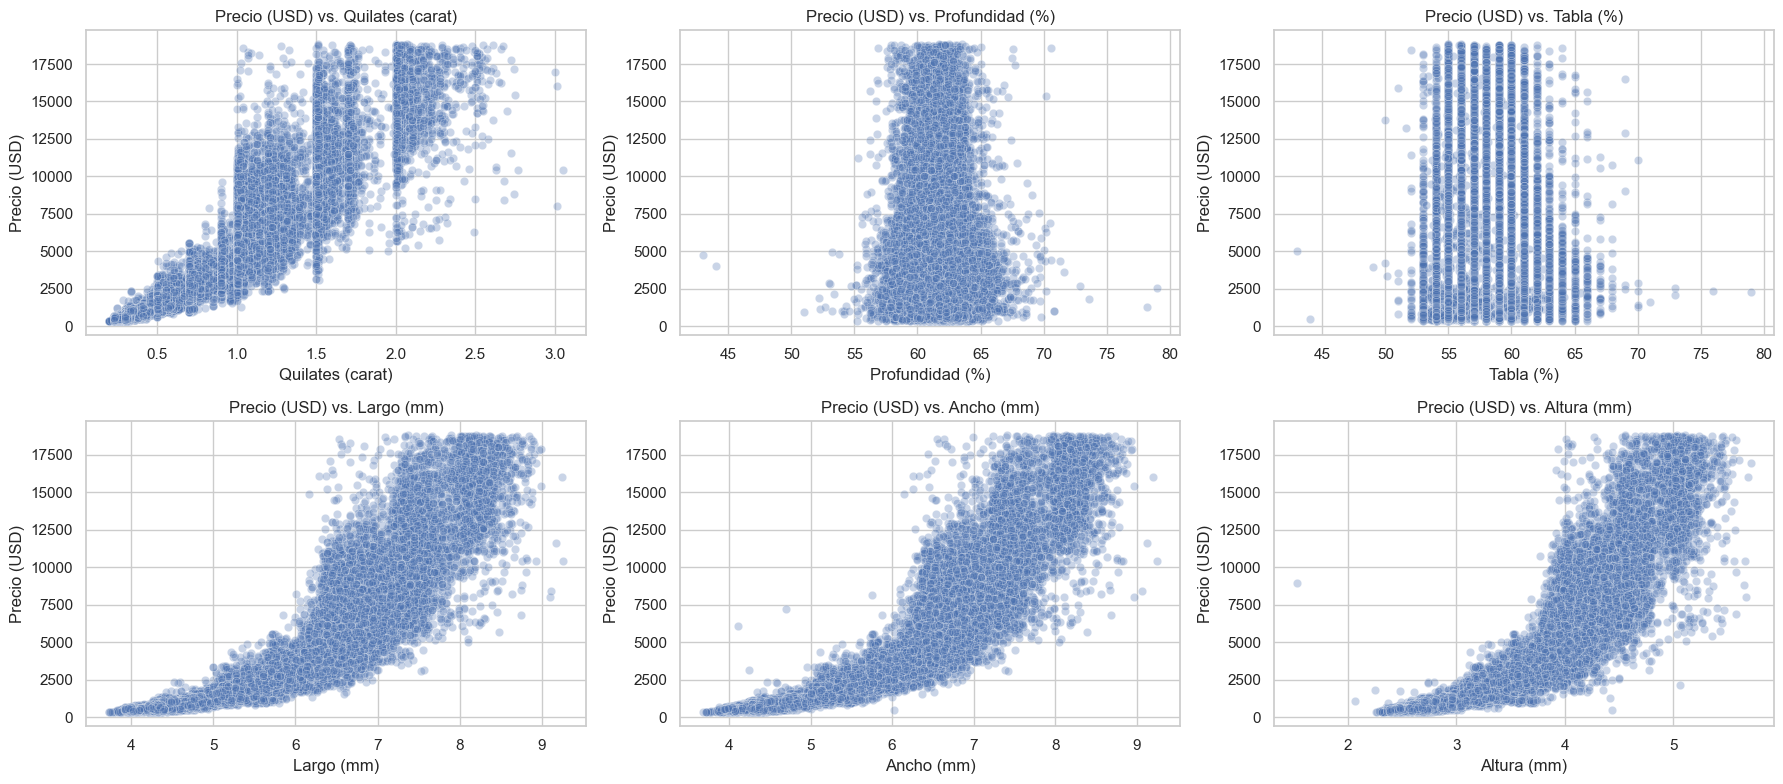

In [166]:
train_df = x_train_filtered.copy()
train_df["price"] = y_train_filtered

num_cols = x_train_filtered.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.scatterplot(x=col, y="price", data=train_df, alpha=0.3, ax=ax)
    ax.set_title(f"{column_labels['price']} vs. {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel(column_labels["price"])
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
plt.tight_layout()
plt.show()

##### Diagramas de cajas

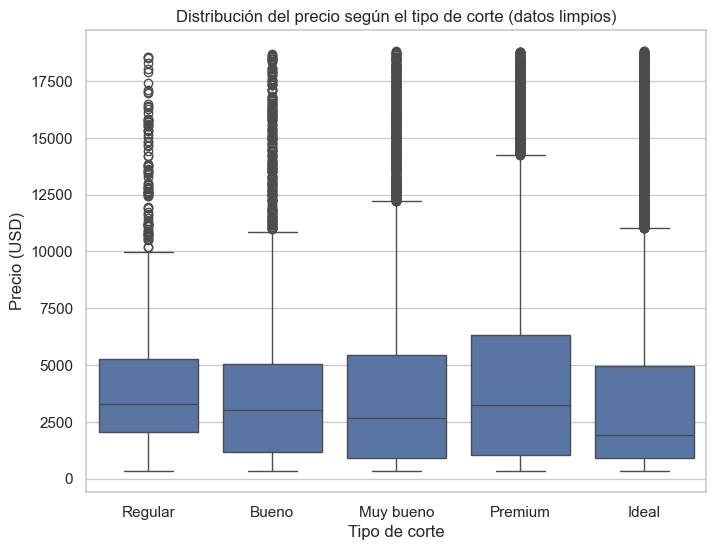

In [167]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="cut",
    y="price",
    data=train_df,
    order=cut_order,
)
plt.title("Distribución del precio según el tipo de corte (datos limpios)")
plt.xlabel("Tipo de corte")
plt.ylabel(column_labels["price"])
plt.xticks(range(len(cut_order)), [cut_labels[int(cat)] for cat in cut_order])
plt.show()

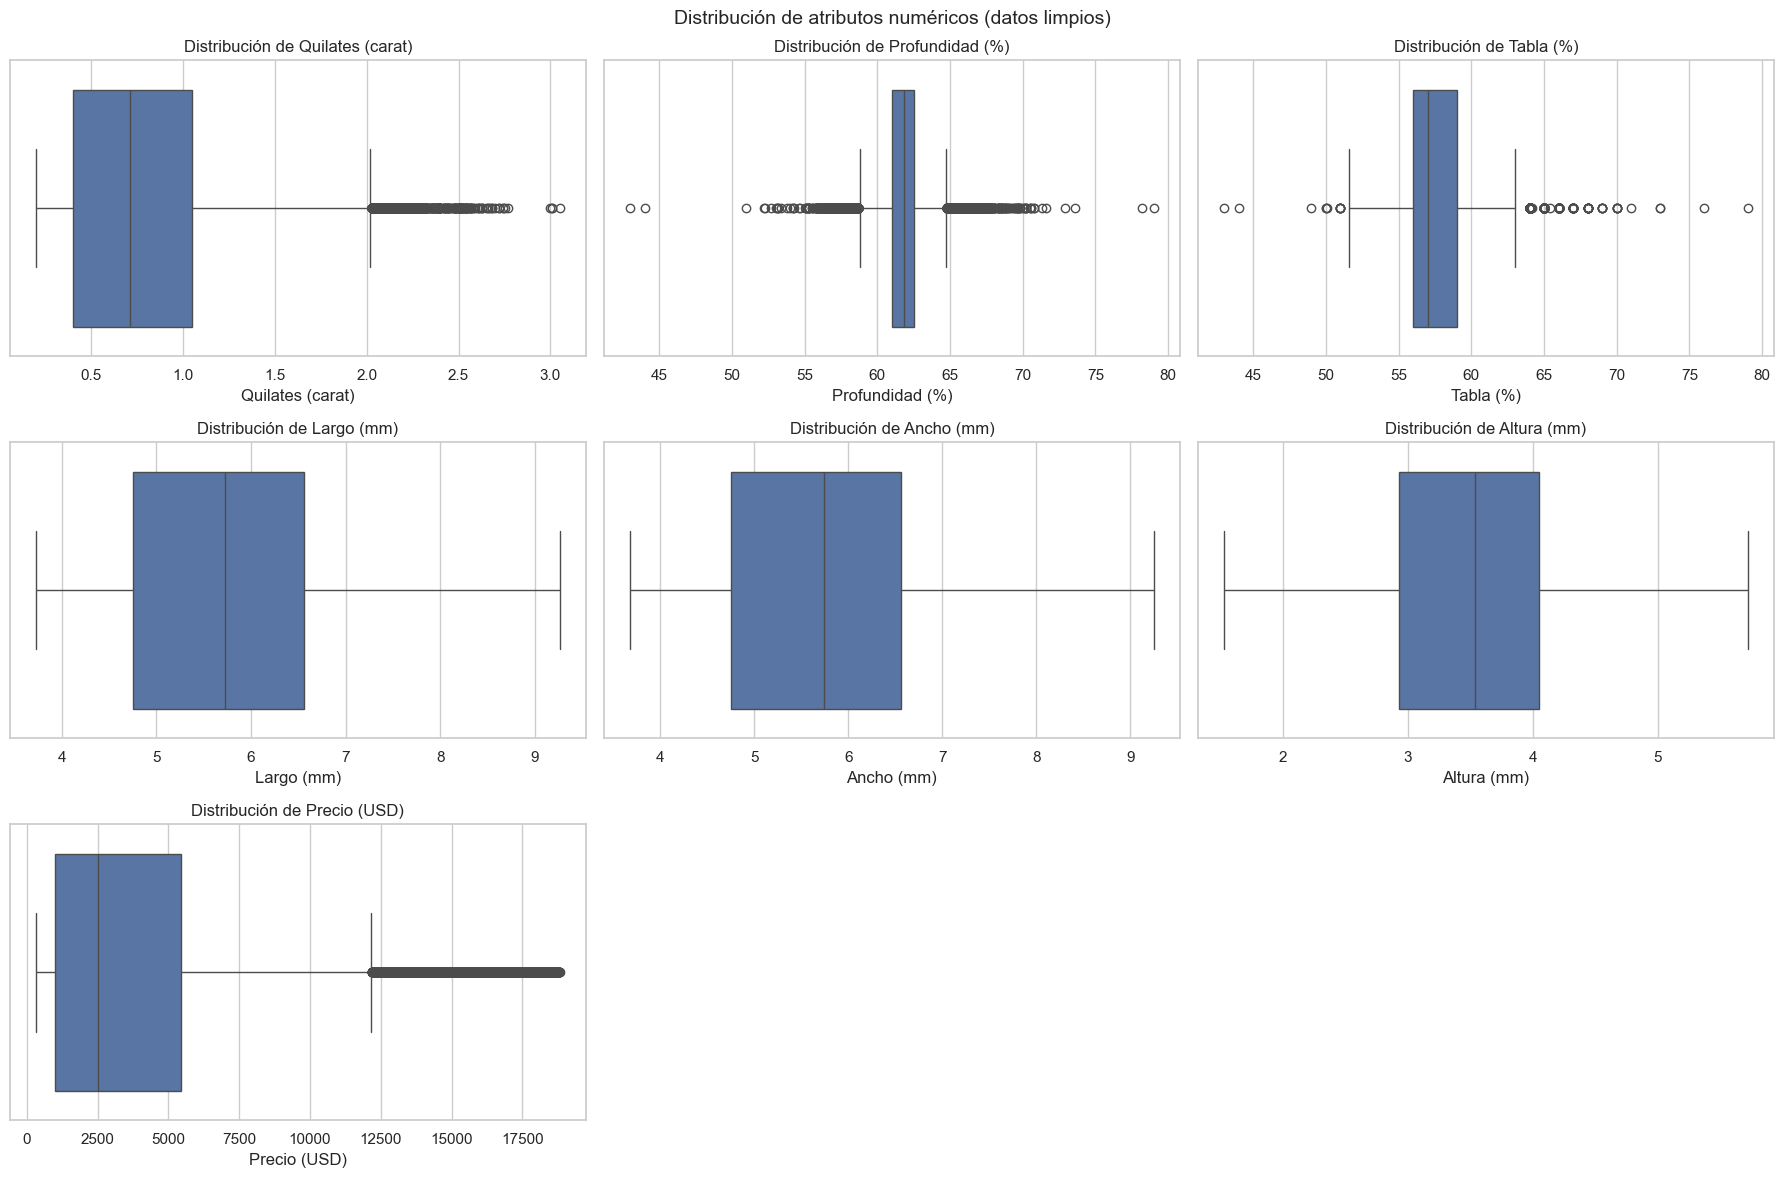

In [168]:
num_cols = train_df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.boxplot(x=col, data=train_df, ax=ax, orient="h")
    ax.set_title(f"Distribución de {column_labels.get(col, col)}")
    ax.set_xlabel(column_labels.get(col, col))
    ax.set_ylabel("")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos numéricos (datos limpios)", fontsize=14)
fig.tight_layout()
plt.show()

##### Histogramas

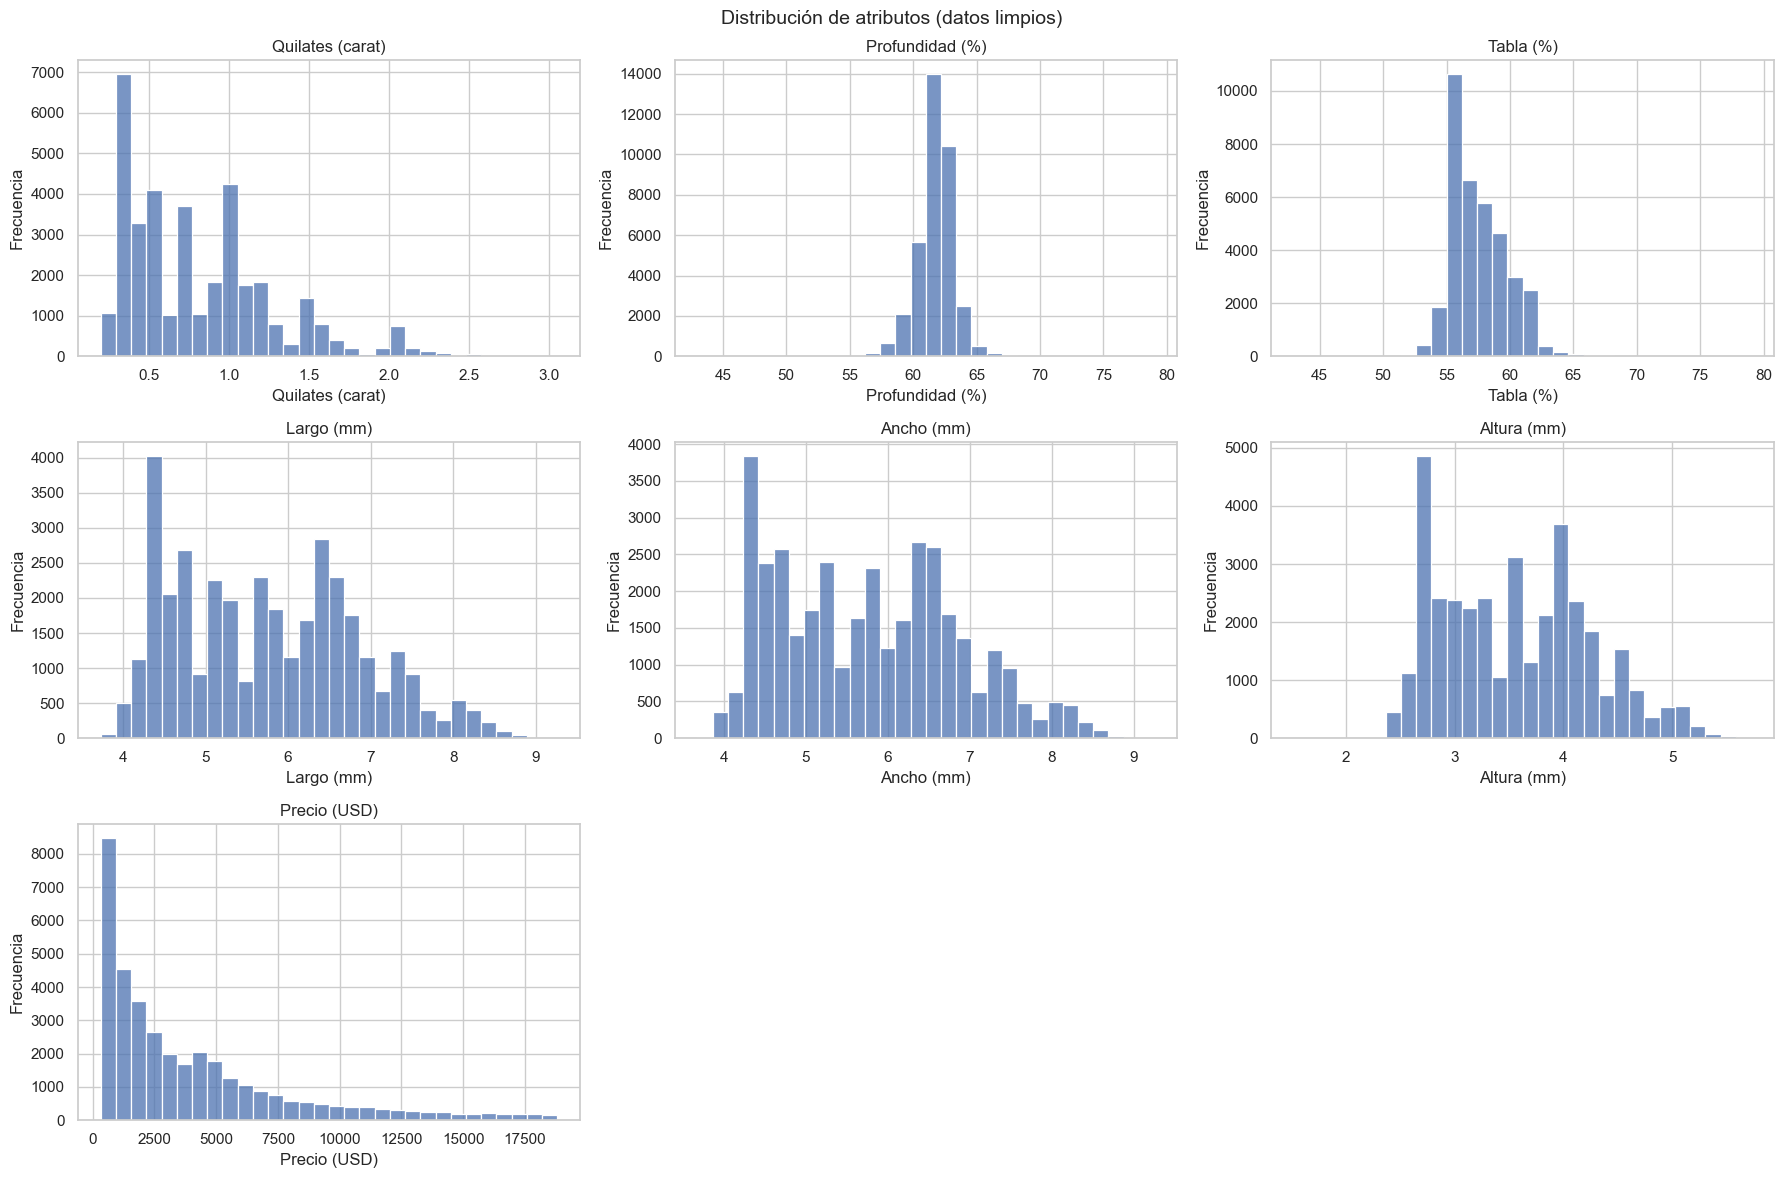

In [169]:
num_cols = train_df.select_dtypes(include="number").columns
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=train_df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos (datos limpios)", fontsize=14)
fig.tight_layout()
plt.show()

### 4 (5 puntos)
- Realice selección de atributos.
- Debe utilizar al menos una técnica para justificar su decisión (De entre los métodos: Filter, Wrapper, Embedded).
- Comente sus conclusiones.

---

La técnica que deseamos utilizar para la selección de atributos es la de _Filter_, ya que es una técnica sencilla y con el análisis previo pudimos observar que varios atributos no aportan información significativa para la predicción del precio.

Con el código a continuación podemos observar la correlación entre los diferentes atributos del `DataFrame` y `price`. Se debe tomar en consideración que esta es la misma correlación que se mostró anteriormente.

In [170]:
corr_with_price = train_df.corr()["price"].drop("price")

correlation_table = (
    corr_with_price.to_frame(name="correlación")
    .assign(correlación_abs=lambda df_: df_["correlación"].abs())
    .sort_values("correlación_abs", ascending=False)
)

display(correlation_table)

,correlación,correlación_abs
carat,0.922755,0.922755
y,0.887984,0.887984
x,0.886648,0.886648
z,0.881958,0.881958
table,0.108540,0.108540
cut,-0.039369,0.039369
depth,-0.003236,0.003236


Esta tabla muestra que los atributos `carat`, `x`, `y` y `z` tienen una correlación significativa con `price`, pero a como vimos anteriormente, `x`, `y` y `z` están altamente correlacionados entre sí y con `carat`. Por lo tanto, se decidió conservar solo `carat` y eliminar `x`, `y` y `z`.

Una vez descartadas estas variables redundantes, completamos el conjunto con `cut` y `table`. Aunque su correlación individual con `price` es más baja, son los siguientes atributos con mayor aporte dentro de los restantes y ofrecen señales complementarias (una categórica y otra numérica). En ese sentido, `carat`, `table` y `cut` conforman nuestro _top 3_ posterior a la depuración por colinealidad.

In [171]:
x_train_selected = x_train_filtered.drop(columns=["x", "y", "z", "depth"])
x_test_selected = x_test_filtered.drop(columns=["x", "y", "z", "depth"])

### 1.5 (5 puntos)
- Escale los datos.
- Comente qué técnica utilizó y por qué.
- Guarde el archivo ya pre-procesado con el nombre: "'diamondsPROCESADO"

**Nota:** No olvide cómo manejará el "bias" (o agregar columna de unos, o si la implementación de los algoritmos que utilizará permiten indicarle que lo agregue).

---

Con el código a continuación se realiza el escalamiento de los datos.

Antes de escalar, aplicamos `log1p` a `carat` porque su distribución es fuertemente asimétrica y la transformación suaviza las colas largas que podrían dominar los ajustes lineales. Posteriormente usamos `MinMaxScaler` para llevar los atributos numéricos a un rango común $[0, 1]$; esto facilita la interpretación de los coeficientes en `LinearRegression` y evita que diferencias de escala afecten la distancia euclidiana durante la validación cruzada. Para la variable categórica `cut` empleamos `OneHotEncoder(drop="first")`, de modo que representamos el corte con variables binarias sin introducir colinealidad perfecta. Finalmente, no agregamos una columna explícita de unos porque las implementaciones de `LinearRegression` y `DecisionTreeRegressor` de `sklearn` manejan el término de sesgo (`fit_intercept=True` por defecto) de forma interna.

In [172]:
numeric_cols = ["carat", "table"]
categorical_cols = ["cut"]

log1p_numeric = FunctionTransformer(lambda data: data.assign(carat=np.log1p(data["carat"])), validate=False)
numeric_pipeline = Pipeline(steps=[("log1p", log1p_numeric), ("scaler", MinMaxScaler())])

categorical_pipeline = Pipeline(
    steps=[("onehot", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))]
)

diamonds_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols),
    ],
    verbose_feature_names_out=False,
)

x_train_raw = cast(DataFrame, diamonds_preprocessor.fit_transform(x_train_selected))
x_test_raw = cast(DataFrame, diamonds_preprocessor.transform(x_test_selected))

y_train = np.log1p(y_train_filtered)
y_test = np.log1p(y_test_filtered)

diamonds_train_processed = x_train_raw.assign(price_log=y_train, price=y_train_filtered, split="train")
diamonds_test_processed = x_test_raw.assign(price_log=y_test, price=y_test_filtered, split="test")
diamonds_processed = (
    pd.concat([diamonds_train_processed, diamonds_test_processed], axis=0).sort_index().reset_index(drop=True)
)
diamonds_processed.to_csv("./data/diamondsPROCESADO.csv", index=False)

Estas decisiones de preprocesamiento buscan mejorar la estabilidad numérica y evitar sesgos en los modelos posteriores:
- Transformar `carat` y `price` con `log1p` mitiga la fuerte asimetría de ambas distribuciones para que los algoritmos lineales se desempeñen mejor.
- Escalar las variables numéricas con `MinMaxScaler` evita que diferencias de magnitud dominen el ajuste; y codificar `cut` con _one-hot encoding_ elimina la falsa noción de orden inherente a su codificación original.
- Al guardar el conjunto resultante, con etiquetas que recuerdan su partición de origen, garantizamos que cualquier experimento futuro parta de exactamente del mismo punto.

### 1.6 (15 puntos)
Presente e implemente un diseño experimental que incluya:
- Dos algoritmos diferentes:
    - Uno será la regresión lineal de mínimos cuadrados sin regularización (OLSR).
    - Usted elegirá un método más, que no sea de los vistos en clase. Si tiene dudas de si puede o no usar algún método, puede consultar al profesor. Para el segundo método deberá elegir al menos un hiperparámetro.
    - Como el OLSR no tiene hiperparámetros, use todo el train/validation para entrenar. Para el otro método, debe usar ten-cross-validation para seleccionar al menos un hiperparámetro.
    - Debe registrar las métricas RMSE y R2. Usted decide cuál de estas dos métricas usa para seleccionar la mejor configuración (Justifique su selección).

**Nota:** Para el algoritmos seleccionado (no el OLSR) explique los parámetros que recibe según la biblioteca utilizada.

---

#### 1.6.1 OLSR (LinearRegression)

A continuación se muestra la implementación del modelo de regresión lineal ordinaria (OLSR) utilizando la clase `LinearRegression` de la biblioteca `sklearn`. Este modelo no tiene hiperparámetros que ajustar, por lo que se entrena directamente con todo el conjunto de entrenamiento y validación.

In [173]:
olsr_model = LinearRegression()
olsr_model.fit(x_train_raw, y_train)
olsr_y_pred = olsr_model.predict(x_test_raw)

olsr_r2: float = r2_score(np.expm1(y_test), np.expm1(olsr_y_pred))
olsr_rmse: float = root_mean_squared_error(np.expm1(y_test), np.expm1(olsr_y_pred))

print(f"R²: {olsr_r2:.4f}")
print(f"RMSE: {olsr_rmse:.4f}")

R²: 0.5716
RMSE: 2586.8687


#### 1.6.2 Decision Tree Regressor (DTR)

Como segundo método se eligió el modelo de árbol de decisión para regresión (`DecisionTreeRegressor`). Este modelo es capaz de capturar relaciones no lineales entre las variables predictoras y la variable objetivo, lo que puede ser beneficioso dado que la relación entre los atributos y el precio del diamante no es estrictamente lineal.

A continuación se muestra la implementación del modelo de árbol de decisión para regresión utilizando la clase `DecisionTreeRegressor` de la biblioteca `sklearn`. En este caso, se utiliza validación cruzada con 10 particiones (10-fold cross-validation) para seleccionar los mejores hiperparámetros basados en la métrica RMSE (Root Mean Squared Error).

Se eligió utilizar RMSE como métrica de selección de hiperparámetros porque penaliza más los errores grandes en la predicción, lo cual es importante en este contexto donde los precios de los diamantes pueden variar significativamente.

Los hiperparámetros que se ajustarán mediante validación cruzada son:
- `max_depth`: profundidad máxima del árbol (controla complejidad/_overfitting_).
- `min_samples_leaf`: mínimo de muestras en una hoja (suaviza predicciones).
- `min_samples_split`: mínimo para dividir un nodo.

In [174]:
tree = DecisionTreeRegressor(random_state=42)

param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_leaf": [1, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # Negativo para maximizar
    cv=cv,
    n_jobs=-1,
    refit=True,  # Se reentrena con los mejores hiperparámetros
)
gs.fit(x_train_raw, y_train)

print("Mejores hiperparámetros (CV por RMSE):", gs.best_params_)
print(f"RMSE medio CV (neg): {gs.best_score_:.4f}")

tree_y_pred = gs.predict(x_test_raw)

tree_rmse = root_mean_squared_error(np.expm1(y_test), np.expm1(tree_y_pred))
tree_r2 = r2_score(np.expm1(y_test), np.expm1(tree_y_pred))

print(f"R²: {tree_r2:.4f}")
print(f"RMSE: {tree_rmse:.4f}")

Mejores hiperparámetros (CV por RMSE): {'max_depth': 9, 'min_samples_leaf': 20, 'min_samples_split': 2}
RMSE medio CV (neg): -0.2413
R²: 0.8764
RMSE: 1389.5620


### 1.7 (5 puntos)
- Por medio de una tabla u otro método idóneo que Usted determine, resuma todos los resultados obtenidos (o la mayoría).
- Grafique comparativamente los valores del real versus el predicho (test), de cada uno de los métodos utilizados.
- Qué conclusiones finales saca sobre los métodos usados como predictores.

---

Para sintetizar los resultados principales, a continuación se construye una tabla con las métricas obtenidas por cada modelo y un breve resumen que facilita comparar su desempeño.

In [175]:
results_summary = (
    pd.DataFrame(
        {
            "Modelo": ["Regresión lineal (OLSR)", "Árbol de decisión (DTR)"],
            "RMSE": [olsr_rmse, tree_rmse],
            "R²": [olsr_r2, tree_r2],
        }
    )
    .set_index("Modelo")
    .sort_values("RMSE")
)

best_rmse_model = results_summary["RMSE"].idxmin()
best_r2_model = results_summary["R²"].idxmax()

display(results_summary.style.format({"RMSE": "{:.2f}", "R²": "{:.3f}"}))

,RMSE,R²
Modelo,,
Árbol de decisión (DTR),1389.56,0.876
Regresión lineal (OLSR),2586.87,0.572


Las conclusiones clave son las siguientes:
- El modelo con menor RMSE es **Árbol de decisión (DTR)**, por lo que reduce en mayor medida los errores grandes.
- El mayor R² corresponde a **Árbol de decisión (DTR)**, lo que indica que explica la mayor proporción de la variabilidad del precio.

Debido a esto el modelo más recomendado para este conjunto de datos es el **Árbol de decisión (DTR)**, ya que maneja mejor la complejidad inherente a la predicción del precio de los diamantes en comparación con la **Regresión lineal (OLSR)**.

A continuación se presentan dos gráficos (uno por modelo) con los valores reales del conjunto de prueba (sin transformaciones) y las predicciones obtenidas sobre esos mismos diamantes.

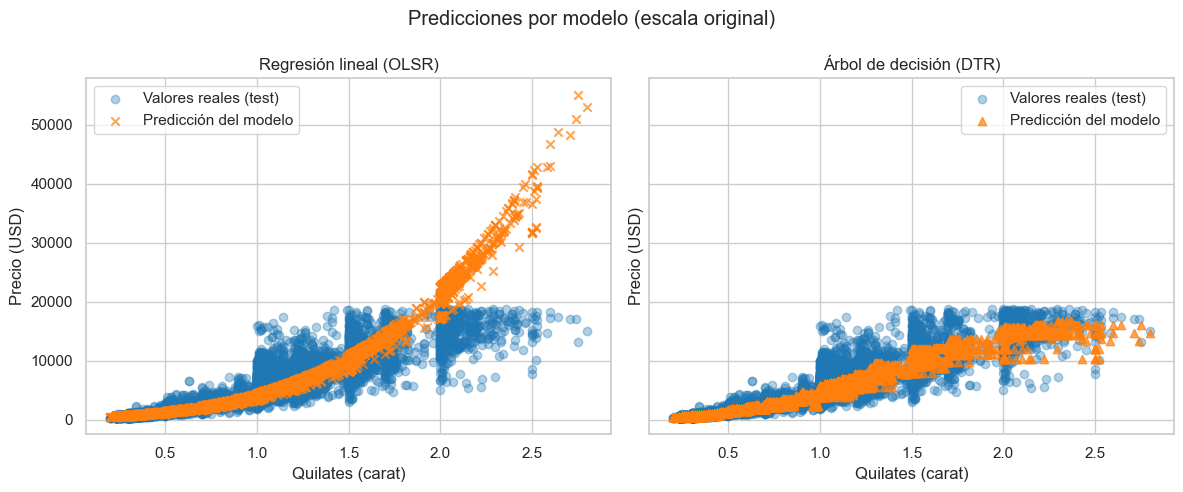

In [176]:
y_test_real = np.expm1(y_test)
olsr_pred_real = np.expm1(olsr_y_pred)
tree_pred_real = np.expm1(tree_y_pred)
carat_test_real = x_test_selected["carat"].to_numpy()

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)

plots = [
    ("Regresión lineal (OLSR)", olsr_pred_real, "tab:orange", "x"),
    ("Árbol de decisión (DTR)", tree_pred_real, "tab:orange", "^"),
]

for ax, (title, preds, color, marker) in zip(axes, plots):
    ax.scatter(carat_test_real, y_test_real, alpha=0.35, label="Valores reales (test)", color="tab:blue")
    ax.scatter(
        carat_test_real,
        preds,
        alpha=0.7,
        label="Predicción del modelo",
        color=color,
        marker=marker,
    )
    ax.set(title=title, xlabel=column_labels["carat"], ylabel=column_labels["price"])
    ax.legend()

fig.suptitle("Predicciones por modelo (escala original)")
plt.tight_layout()
plt.show()

Con estos gráficos se puede observar que el modelo de árbol de decisión captura mejor la variabilidad en los precios, especialmente en los rangos más altos, en los que la regresión lineal tiene dificultades para ajustarse adecuadamente (la **Regresión lineal (OLSR)** despega luego de los 2 quilates). Si bien el árbol tiende a subestimar ligeramente los diamantes más pesados, sus errores siguen siendo mucho menores que las sobreestimaciones pronunciadas del modelo lineal.

___

# Parte 2 - Clasificación (50 puntos)

### Considere lo siguiente:
1. Conjunto de datos: **cardio.csv**
2. Algunos detalles del conjunto de datos los puede ver en: <https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset>.
3. El atributo a predecir es: **cardio**.
4. Proponga al menos dos algoritmos a utilizar
5. Métricas:
    1. Accuracy
    2. Ustedes propongan una más.
6. Debe presentar en este cuaderno:
    1. Pre-procesamiento de los datos, explicando las decisiones en cada caso.
    2. Para cada uno de los algoritmos seleccionados:
        1. Explicación del algoritmo.
        2. Explicación de la implementación seleccionada y de sus parámetros (según la biblioteca).
    4. Explicación del diseño experimental por ejecutar. Recuerde que si el algoritmo requiere seleccionar hiperparámetros, hay que dividir en tres conjuntos de datos: Training, Validation, Testing (60%, 20%, 20%). Se le recomienda confirmar con el profesor cuántos y cuáles hiperparámetros validar.
    5. Programación del diseño experimental.
    6. Tablas de resultados, gráficos y conclusiones de los resultados, recomendando a su contratante cuál algoritmo utilizar, con qué configuración y por qué lo recomienda.

---

#### Pre-procesamiento de los datos

Primero, empezamos cargando el conjunto de datos y eliminando la columna `id`, ya que no aporta información relevante para la predicción. También podemos ver las primeras 10 filas, para notar la estructura del `DataFrame`.

In [177]:
df = pd.read_csv("./data/cardio.csv", sep=";", encoding="utf-8")

df = df.drop("id", axis=1)

df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0
5,21143,1,164,61.0,100,70,1,1,0,0,1,0
6,18085,1,162,72.0,100,70,1,1,0,0,1,0
7,22547,1,161,93.0,140,90,2,1,0,0,1,1
8,21250,1,157,68.0,110,80,1,1,0,0,1,0
9,22446,1,158,65.0,140,90,3,1,0,0,1,1


A continuación, se realiza un cambio de tipo a los valores categóricos y se crea un diccionario para el etiquetado de los valores en los gráficos.

In [178]:
category_columns = ["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]
df[category_columns] = df[category_columns].astype("category")

En el siguiente bloque de código está el etiquetado para cada una de las variables categóricas.

In [179]:
category_labels = {
    "gender": ["Femenino", "Masculino"],
    "cholesterol": ["Normal", "Por encima de lo normal", "Muy por encima de lo normal"],
    "gluc": ["Normal", "Por encima de lo normal", "Muy por encima de lo normal"],
    "smoke": ["No fumador", "Fumador"],
    "alco": ["No consume alcohol", "Consume alcohol"],
    "active": ["Inactivo", "Activo"],
    "cardio": ["Sin enfermedad", "Con enfermedad"],
}

value_label_map = {column: dict(zip(df[column].cat.categories, labels)) for column, labels in category_labels.items()}

A continuación se detalla un diccionario de etiquetas descriptivas en español para cada columna, el cual se reutiliza en los títulos y ejes de los gráficos.

In [180]:
column_labels = {
    "age": "Edad (días)",
    "gender": "Sexo",
    "height": "Estatura (cm)",
    "weight": "Peso (kg)",
    "ap_hi": "Presión sistólica (mm Hg)",
    "ap_lo": "Presión diastólica (mm Hg)",
    "cholesterol": "Colesterol (1–3)",
    "gluc": "Glucosa (1–3)",
    "smoke": "¿Fuma? (0/1)",
    "alco": "¿Consume alcohol? (0/1)",
    "active": "Actividad física (0/1)",
    "cardio": "Diagnóstico cardiovascular",
}

A continuación se muestran las primeras 10 filas del `DataFrame` procesado:

In [181]:
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0
5,21143,1,164,61.0,100,70,1,1,0,0,1,0
6,18085,1,162,72.0,100,70,1,1,0,0,1,0
7,22547,1,161,93.0,140,90,2,1,0,0,1,1
8,21250,1,157,68.0,110,80,1,1,0,0,1,0
9,22446,1,158,65.0,140,90,3,1,0,0,1,1


Además, se muestra la información de cada columna y la cantidad de registros (y registros no nulos):

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          69301 non-null  int64   
 1   gender       69301 non-null  category
 2   height       69301 non-null  int64   
 3   weight       69301 non-null  float64 
 4   ap_hi        69301 non-null  int64   
 5   ap_lo        69301 non-null  int64   
 6   cholesterol  69301 non-null  category
 7   gluc         69301 non-null  category
 8   smoke        69301 non-null  category
 9   alco         69301 non-null  category
 10  active       69301 non-null  category
 11  cardio       69301 non-null  category
dtypes: category(7), float64(1), int64(4)
memory usage: 3.1 MB


Como se puede observar, no hay valores nulos en el conjunto de datos y este cuenta con 69301 registros.

Después de eso, procedemos a eliminar las filas duplicadas del conjunto de datos y comprobamos cuántas filas quedan.

In [183]:
df = df.drop_duplicates()
df.shape[0]

69277

Como se puede ver la cantidad de filas ahora es de 69277, por lo que se eliminaron 24 filas duplicadas.

Finalmente, antes de empezar con el análisis exploratorio de los datos, ajustamos los valores de `ap_hi` y `ap_lo` que caen fuera de los rangos fisiológicos esperados. En particular, acotamos la presión sistólica a $[70, 250]$ mm Hg y la diastólica a $[40, 150]$ mm Hg. Este recorte evita que mediciones claramente erróneas, por debajo de límites vitales o muy por encima de lo médicamente plausible, distorsionen las distribuciones y los modelos posteriores.

In [184]:
df["ap_hi"] = df["ap_hi"].clip(lower=70, upper=250)
df["ap_lo"] = df["ap_lo"].clip(lower=40, upper=150)

Para analizar las dependencias entre variables numéricas y categóricas utilizamos la función `associations` de la librería `dython`, la cual genera una matriz de relaciones comparable entre atributos de distinto tipo.

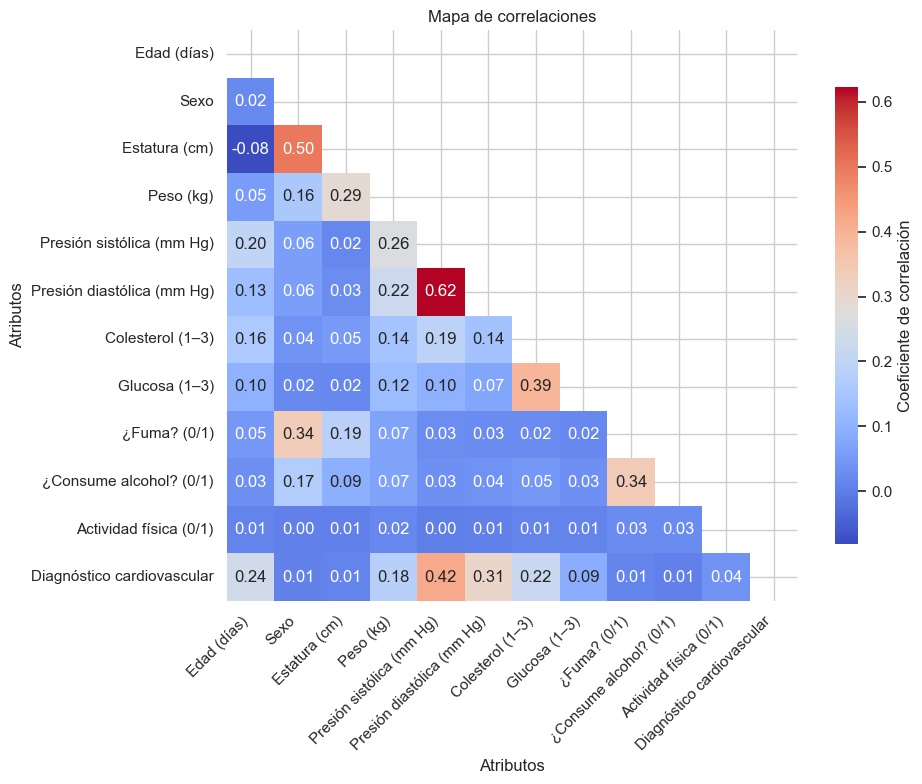

In [185]:
association_results = associations(
    df,
    nominal_columns=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
    plot=False,
)

association_matrix = association_results["corr"]
column_name_map = {col: column_labels.get(col, col) for col in association_matrix.columns}
association_matrix = association_matrix.rename(index=column_name_map, columns=column_name_map)

mask = np.triu(np.ones_like(association_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    association_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"label": "Coeficiente de correlación", "shrink": 0.8},
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Mapa de correlaciones")
plt.xlabel("Atributos")
plt.ylabel("Atributos")
plt.tight_layout()
plt.show()

Este mapa confirma que no existen dependencias extremadamente fuertes, pero sí aparecen asociaciones moderadas: el sexo se relaciona con la estatura (0.50), la glucosa con el colesterol (0.39) y la variable objetivo `cardio` muestra vínculos apreciables con edad (0.24), colesterol (0.22) y peso (0.18). Estos hallazgos justifican conservar todas las variables para el modelado posterior.

A continuación se muestran los histogramas de las variables numéricas del conjunto de datos. Se puede notar que en presión sanguínea la mayoría de los valores se encuentran cerca del límite superior.

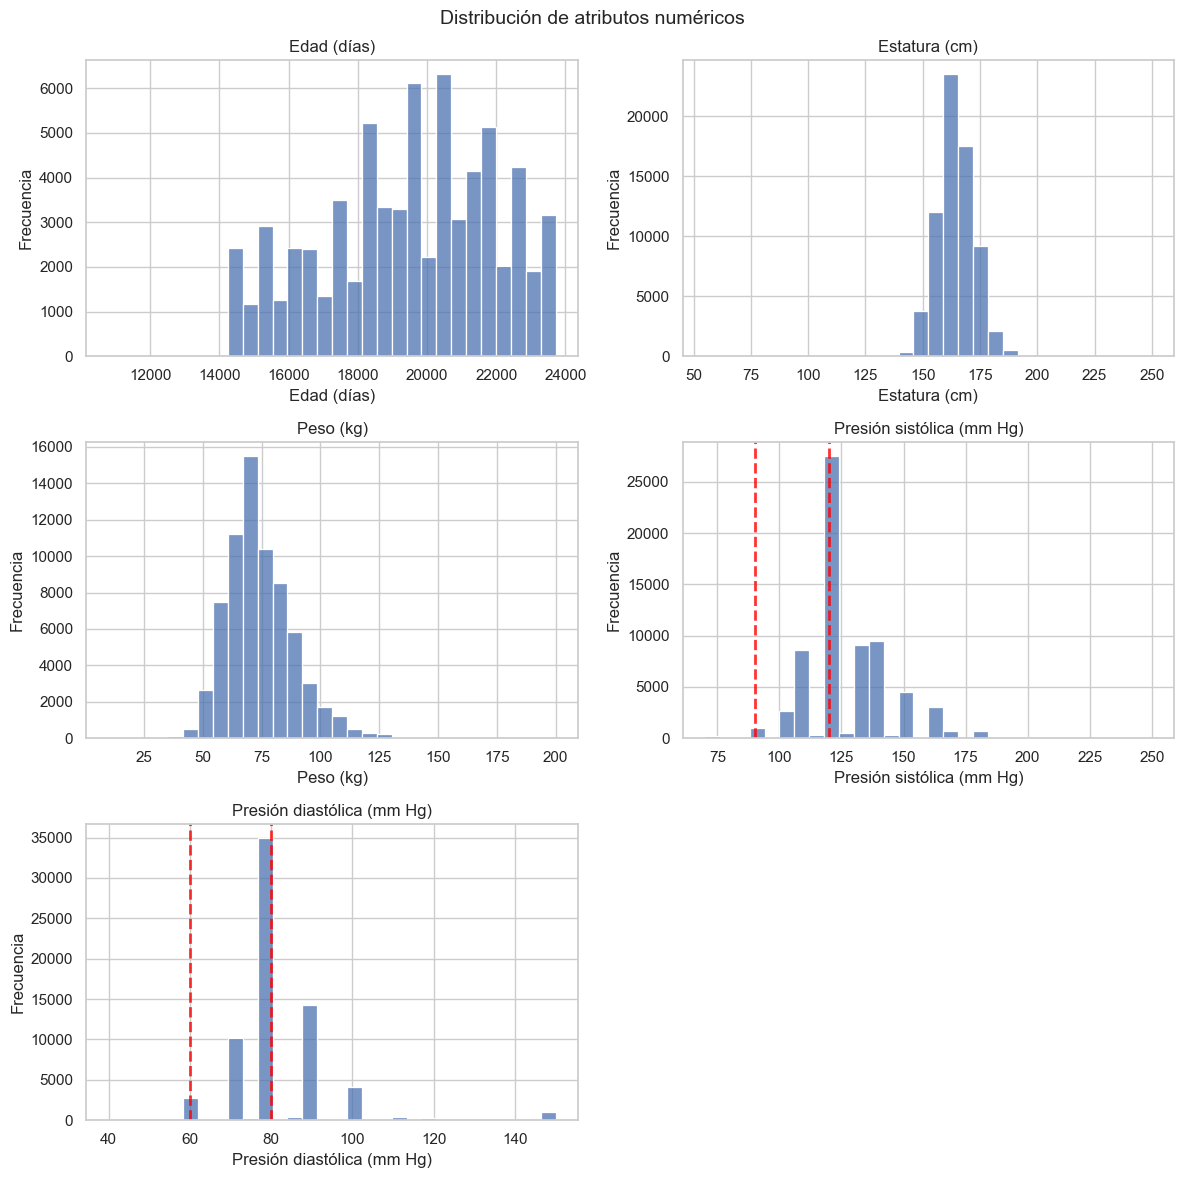

In [186]:
num_cols = df.select_dtypes(include="number").columns
ncols = 2
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
for ax, col in zip(axes.flat, num_cols):
    sns.histplot(x=df[col], bins=30, ax=ax, stat="count", color="#4C72B0", edgecolor="white")
    label = column_labels.get(col, col)
    if col == "ap_hi":
        ax.axvline(90, color="red", linestyle="--", linewidth=2, alpha=0.8)
        ax.axvline(120, color="red", linestyle="--", linewidth=2, alpha=0.8)
    if col == "ap_lo":
        ax.axvline(60, color="red", linestyle="--", linewidth=2, alpha=0.8)
        ax.axvline(80, color="red", linestyle="--", linewidth=2, alpha=0.8)
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frecuencia")
for ax in axes.flat[len(num_cols) :]:
    ax.remove()
fig.suptitle("Distribución de atributos numéricos", fontsize=14)
fig.tight_layout()
plt.show()

Con el fin de observar diferencias por clase objetivo, se incluyen diagramas de caja para las variables numéricas más relevantes.

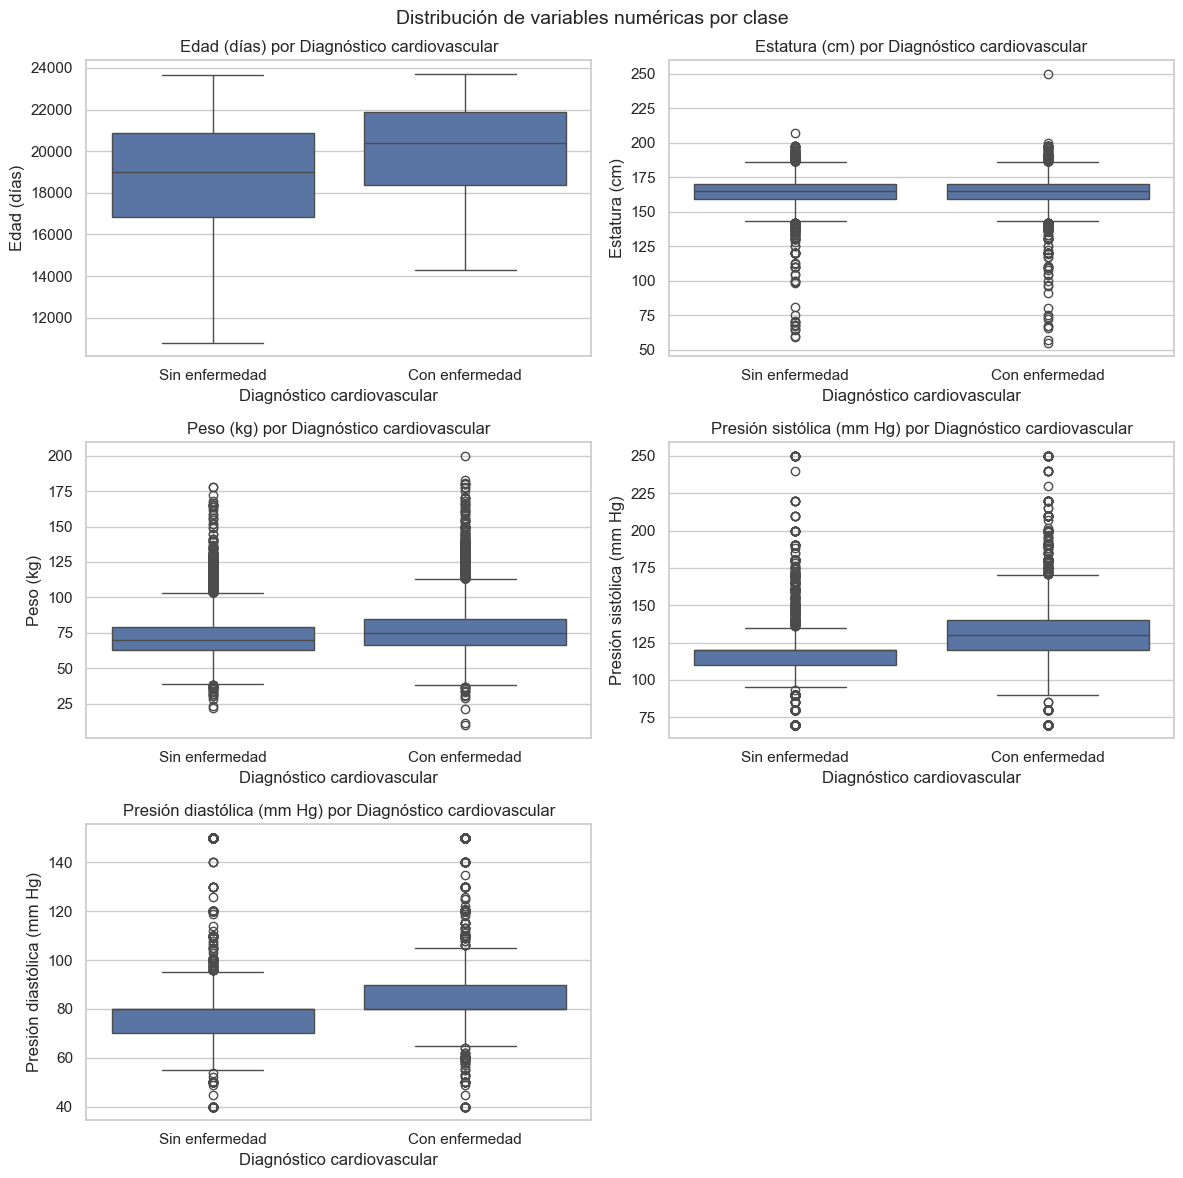

In [187]:
ncols = 2
nrows = math.ceil(len(num_cols) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))

for ax, col in zip(axes.flat, num_cols):
    sns.boxplot(x="cardio", y=col, data=df, ax=ax)
    ax.set_xlabel(column_labels["cardio"])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(category_labels["cardio"])
    ax.set_ylabel(column_labels.get(col, col))
    ax.set_title(f"{column_labels.get(col, col)} por {column_labels['cardio']}")

for ax in axes.flat[len(num_cols) :]:
    ax.remove()

fig.suptitle("Distribución de variables numéricas por clase", fontsize=14)
fig.tight_layout()
plt.show()

De acuerdo con estos diagramas, las personas con diagnóstico positivo tienden a ser ligeramente mayores y a presentar mayor dispersión tanto en peso como en presión sanguínea (sistólica y diastólica). Las diferencias en las medianas son pequeñas pero apreciables, especialmente en presión sistólica, lo que sugiere que estos atributos pueden aportar información para el modelo predictivo.

#### Algoritmos seleccionados (Logistic Regression y Random Forest)

- **_Logistic Regression_ (`LogisticRegression`)**: modelo lineal para clasificación binaria que permite interpretar el aporte de cada predictor mediante sus coeficientes. Resulta apropiado como línea base, pues es eficiente, admite regularización y puede ponderar clases si existe desequilibrio entre pacientes con y sin enfermedad cardiovascular.
- **_Random Forest_ (`RandomForestClassifier`)**: ensamble de árboles de decisión entrenados sobre subconjuntos aleatorios de datos y atributos. Captura relaciones no lineales y efectos de interacción que la regresión logística podría pasar por alto, es robusto ante valores atípicos y ofrece medidas de importancia de variables, útiles en contextos médicos.

Para cada modelo se emplearán los siguientes parámetros (que se detallan al programar los experimentos):
- Para `LogisticRegression`, los hiperparámetros más relevantes son:
    - `penalty`: define qué tipo de regularización se aplica (por ejemplo, L1 o L2) para evitar que los coeficientes crezcan sin control.
    - `C`: cuantifica qué tan fuerte es la regularización; valores altos permiten coeficientes más grandes y valores pequeños los restringen.
    - `solver`: elige el algoritmo numérico que resuelve la optimización; algunos manejan mejor ciertas penalizaciones o tamaños de datos.
    - `class_weight`: permite asignar mayor peso a clases minoritarias para que el modelo no las ignore.
    - `max_iter` y `tol`: ajustan cuántas iteraciones realiza el optimizador y cuál es el umbral de convergencia.

- Para `RandomForestClassifier`, conviene documentar:
    - `n_estimators`: número de árboles en el ensamble; más árboles suelen reducir la varianza.
    - `max_depth`, `min_samples_split` y `min_samples_leaf`: limitan qué tan profundos o pequeños pueden ser los nodos para controlar el sobreajuste.
    - `max_features`: restringe cuántos atributos se consideran al dividir un nodo, fomentando la diversidad entre árboles.
    - `bootstrap` y `oob_score`: activan el muestreo con reemplazo y la evaluación Out-of-Bag para estimar desempeño sin un conjunto adicional.
    - `class_weight`: ajusta la influencia de cada clase en la pérdida cuando las clases están desbalanceadas.
    - `random_state` y `n_jobs`: fijan la semilla para reproducibilidad y permiten paralelizar el entrenamiento.

#### Métricas de evaluación

- **Accuracy** (requerida por el enunciado): porcentaje de predicciones correctas sobre el total de observaciones. Proporciona una visión global, aunque puede enmascarar problemas cuando las clases están desbalanceadas.
- **F1-score** (métrica propuesta): media armónica entre precisión y exhaustividad para la clase positiva (`cardio = 1`). Permite equilibrar los costos de falsos positivos y falsos negativos, aspecto relevante en detección de enfermedades donde ambos errores son críticos.

#### Diseño experimental

Primero dividimos el conjunto de datos en entrenamiento (60%), validación (20%) y prueba (20%) utilizando `train_test_split` con estratificación para preservar la proporción de clases.

In [188]:
x = df.drop(columns="cardio", axis=1)
y = df["cardio"]

x_train_val_raw, x_test_raw, y_train_val, y_test = cast(
    tuple[DataFrame, DataFrame, Series, Series],
    train_test_split(x, y, test_size=0.20, random_state=42, stratify=y),
)

x_train_raw, x_val_raw, y_train, y_val = cast(
    tuple[DataFrame, DataFrame, Series, Series],
    train_test_split(x_train_val_raw, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val),
)

Con el siguiente bloque de código podemos validar las dimensiones de cada conjunto y que la proporción de clases se mantiene.

In [189]:
display(
    pd.DataFrame(
        {
            "Conjunto": ["Train", "Validation", "Test"],
            "Filas": [len(x_train_raw), len(x_val_raw), len(x_test_raw)],
            "Positivos (cardio=1)": [
                y_train.astype("int64").sum(),
                y_val.astype("int64").sum(),
                y_test.astype("int64").sum(),
            ],
            "Negativos (cardio=0)": [
                len(y_train) - y_train.astype("int64").sum(),
                len(y_val) - y_val.astype("int64").sum(),
                len(y_test) - y_test.astype("int64").sum(),
            ],
        }
    ).set_index("Conjunto")
)

,Filas,Positivos (cardio=1),Negativos (cardio=0)
Conjunto,,,
Train,41565,20769,20796
Validation,13856,6923,6933
Test,13856,6923,6933


Con el código a continuación hacemos preprocesamiento de los datos, escalando las variables numéricas y codificando las categóricas mediante _one-hot encoding_.

In [190]:
num_cols = x.select_dtypes(include="number").columns
cat_cols = x.select_dtypes(include="category").columns


numeric_preprocess = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocess = Pipeline(
    steps=[("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False))]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols),
    ],
    remainder="drop",
)

preprocess.fit(x_train_raw)

x_train = preprocess.transform(x_train_raw)
x_val = preprocess.transform(x_val_raw)
x_test = preprocess.transform(x_test_raw)
x_train_val = preprocess.transform(x_train_val_raw)

#### Programación del diseño experimental

##### `LogisticRegression`

Para la regresión logística vamos a hacer una búsqueda de hiperparámetros usando validación cruzada de 10 _folds_ sobre el conjunto de entrenamiento. Vamos a probar diferentes valores para el parámetro de regularización `C` y el tipo de penalización (`l1`, `l2`). Una vez que encontremos los mejores hiperparámetros, entrenamos el modelo final con todo el conjunto de entrenamiento y validación combinados.

###### Explicación de los hiperparámetros

- `penalty`: define el tipo de regularización. Probamos `l1` (que puede eliminar características irrelevantes poniendo sus coeficientes en cero) y `l2` (que solo reduce los coeficientes pero no los elimina completamente). Esto nos ayuda a encontrar qué tipo de regularización funciona mejor para nuestros datos.
- `C`: controla la fuerza de la regularización. Valores pequeños (como 0.01) aplican mucha regularización (modelo más simple), mientras que valores grandes (como 100) aplican poca regularización (modelo más complejo). Probamos un _range_ amplio para encontrar el balance correcto.

###### Explicación de los parámetros fijos

- `max_iter=2000`: número máximo de iteraciones para que el algoritmo converja. Lo ponemos en 2000 porque con valores más bajos el modelo puede no terminar de entrenarse correctamente (especialmente con regularización `l1`).
- `class_weight="balanced"`: ajusta automáticamente los pesos de las clases de forma inversa a sus frecuencias. Como nuestro _dataset_ puede estar desbalanceado (más casos sin enfermedad cardiovascular que con enfermedad), esto ayuda a que el modelo no se sesgue hacia la clase mayoritaria.
- `solver="saga"`: es el algoritmo de optimización que se usa para entrenar. Lo elegimos porque es el único que soporta tanto `l1` como `l2` y funciona bien con _datasets_ grandes.
- `random_state=42`: fija la semilla aleatoria para tener reproducibilidad en los resultados.

In [191]:
log_reg = LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga", random_state=42)

log_param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10, 100],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

log_search = GridSearchCV(
    estimator=log_reg,
    param_grid=log_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True,
)
log_search.fit(x_train, y_train)

print("Mejores hiperparámetros (F1 CV):", log_search.best_params_)
print(f"Mejor F1 medio CV: {log_search.best_score_:.4f}")

best_log_reg = log_search.best_estimator_

Mejores hiperparámetros (F1 CV): {'C': 10, 'penalty': 'l2'}
Mejor F1 medio CV: 0.7111


Ahora entrenamos el modelo con los mejores hiperparámetros encontrados usando el conjunto completo de entrenamiento y validación.

In [192]:
best_log_reg.fit(x_train_val, y_train_val)

log_test_pred = best_log_reg.predict(x_test)

print("Accuracy:", accuracy_score(y_test, log_test_pred))
print("F1     :", f1_score(y_test, log_test_pred))
print(classification_report(y_test, log_test_pred, digits=4))

Accuracy: 0.7234411085450346
F1     : 0.7067197305984999
              precision    recall  f1-score   support

           0     0.7010    0.7799    0.7384      6933
           1     0.7516    0.6669    0.7067      6923

    accuracy                         0.7234     13856
   macro avg     0.7263    0.7234    0.7225     13856
weighted avg     0.7263    0.7234    0.7226     13856



###### Interpretación de los resultados

- **Accuracy ($0.7234$)**: el modelo clasifica correctamente el 72.34% de los casos. Esto significa que de cada 100 pacientes, aproximadamente 72 son clasificados correctamente (sea que tengan o no enfermedad cardiovascular).

- **F1-score general ($0.7067$)**: esta métrica combina _precision_ y _recall_ en un solo número. Un valor de 0.71 indica que el modelo tiene un balance razonable entre identificar correctamente los casos positivos y no generar demasiados falsos positivos.

Para la clase 0 (sin enfermedad cardiovascular):
- **Precision ($0.7010$)**: cuando el modelo predice que un paciente NO tiene enfermedad, tiene razón el 70.1% de las veces.
- **Recall ($0.7799$)**: de todos los pacientes que realmente NO tienen enfermedad, el modelo identifica correctamente al 77.99%.
- **F1-score ($0.7384$)**: balance entre _precision_ y _recall_ para esta clase.

Para la clase 1 (con enfermedad cardiovascular):
- **Precision ($0.7516$)**: cuando el modelo predice que un paciente tiene enfermedad, tiene razón el 75.16% de las veces.
- **Recall ($0.6669$)**: de todos los pacientes que realmente tienen enfermedad, el modelo identifica correctamente al 66.69%.
- **F1-score ($0.7067$)**: balance entre _precision_ y _recall_ para esta clase.

El _recall_ más bajo para la clase 1 significa que el modelo no detecta aproximadamente el 33% de los casos de enfermedad cardiovascular (falsos negativos), lo cual puede ser preocupante en un contexto médico.

##### `RandomForest`

Para el _Random Forest_ también hacemos una búsqueda de hiperparámetros con validación cruzada de 10 _folds_. Probamos diferentes combinaciones de número de árboles, profundidad máxima y tamaño mínimo de las hojas. Después de encontrar los mejores hiperparámetros, entrenamos el modelo final con todo el conjunto de entrenamiento y validación.

###### Explicación de los hiperparámetros:

- `n_estimators`: es el número de árboles en el _forest_. Probamos 100 y 200. Más árboles generalmente dan mejores resultados pero toman más tiempo de entrenamiento. Usamos valores moderados para balancear rendimiento y tiempo.
- `max_depth`: controla qué tan profundo puede crecer cada árbol. Probamos 10 y 20 niveles. Profundidades muy grandes pueden causar _overfitting_ (el modelo memoriza el entrenamiento), mientras que muy pequeñas pueden causar _underfitting_ (el modelo es demasiado simple).
- `min_samples_leaf`: define cuántas muestras mínimas debe tener una hoja. Probamos 5 y 10. Valores más altos hacen el modelo más conservador y ayudan a prevenir _overfitting_ al no crear divisiones demasiado específicas.

###### Explicación de los parámetros fijos:

- `random_state=42`: fija la semilla aleatoria para poder reproducir los resultados.
- `class_weight="balanced_subsample"`: ajusta los pesos de las clases automáticamente en cada _bootstrap sample_. Como nuestro _dataset_ puede estar desbalanceado, esto ayuda a que el modelo no favorezca siempre la clase mayoritaria. Usamos `"balanced_subsample"` en lugar de `"balanced"` porque funciona mejor con _Random Forest_ (aplica el balance en cada muestra _bootstrap_).
- `n_jobs=-1`: usa todos los _cores_ disponibles del CPU para entrenar más rápido (especialmente útil porque estamos entrenando muchos árboles).

In [193]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced_subsample", n_jobs=-1)

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_leaf": [5, 10],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True,
)
rf_search.fit(x_train, y_train)

print("Mejores hiperparámetros (F1 CV):", rf_search.best_params_)
print(f"Mejor F1 medio CV: {rf_search.best_score_:.4f}")

best_rf = rf_search.best_estimator_

Mejores hiperparámetros (F1 CV): {'max_depth': 20, 'min_samples_leaf': 10, 'n_estimators': 200}
Mejor F1 medio CV: 0.7232


Ahora entrenamos el modelo con los mejores hiperparámetros encontrados usando el conjunto completo de entrenamiento y validación.

In [194]:
best_rf.fit(x_train_val, y_train_val)

rf_test_pred = best_rf.predict(x_test)

print("Accuracy:", accuracy_score(y_test, rf_test_pred))
print("F1     :", f1_score(y_test, rf_test_pred))
print(classification_report(y_test, rf_test_pred, digits=4))

Accuracy: 0.7313799076212472
F1     : 0.719644471226273
              precision    recall  f1-score   support

           0     0.7140    0.7727    0.7422      6933
           1     0.7519    0.6900    0.7196      6923

    accuracy                         0.7314     13856
   macro avg     0.7330    0.7314    0.7309     13856
weighted avg     0.7329    0.7314    0.7309     13856



###### Interpretación de los resultados:

- **Accuracy ($0.7314$)**: el modelo clasifica correctamente el 73.14% de los casos. Esto significa que de cada 100 pacientes, aproximadamente 73 son clasificados correctamente.

- **F1-score general ($0.7196$)**: esta métrica combina _precision_ y _recall_. Un valor de 0.72 indica un balance razonable entre identificar correctamente los casos positivos y minimizar los falsos positivos.

Para la clase 0 (sin enfermedad cardiovascular):

- **Precision ($0.7140$)**: cuando el modelo predice que un paciente NO tiene enfermedad, tiene razón el 71.4% de las veces.
- **Recall ($0.7727$)**: de todos los pacientes que realmente NO tienen enfermedad, el modelo identifica correctamente al 77.27%.
- **F1-score ($0.7422$)**: balance entre _precision_ y _recall_ para esta clase.

Para la clase 1 (con enfermedad cardiovascular):

- **Precision ($0.7519$)**: cuando el modelo predice que un paciente tiene enfermedad, tiene razón el 75.19% de las veces.
- **Recall ($0.6900$)**: de todos los pacientes que realmente tienen enfermedad, el modelo identifica correctamente al 69%.
- **F1-score ($0.7196$)**: balance entre _precision_ y _recall_ para esta clase.

El _recall_ de 0.69 para la clase 1 indica que el modelo no detecta aproximadamente el 31% de los casos de enfermedad cardiovascular (falsos negativos).

##### Resultados y conclusiones

###### Resumen de resultados

| Modelo | Accuracy | F1-Score |
|--------|----------|----------|
| Regresión Logística | $0.7234$ | $0.7067$ |
| Random Forest | $0.7314$ | $0.7196$ |

###### Matrices de confusión (test)

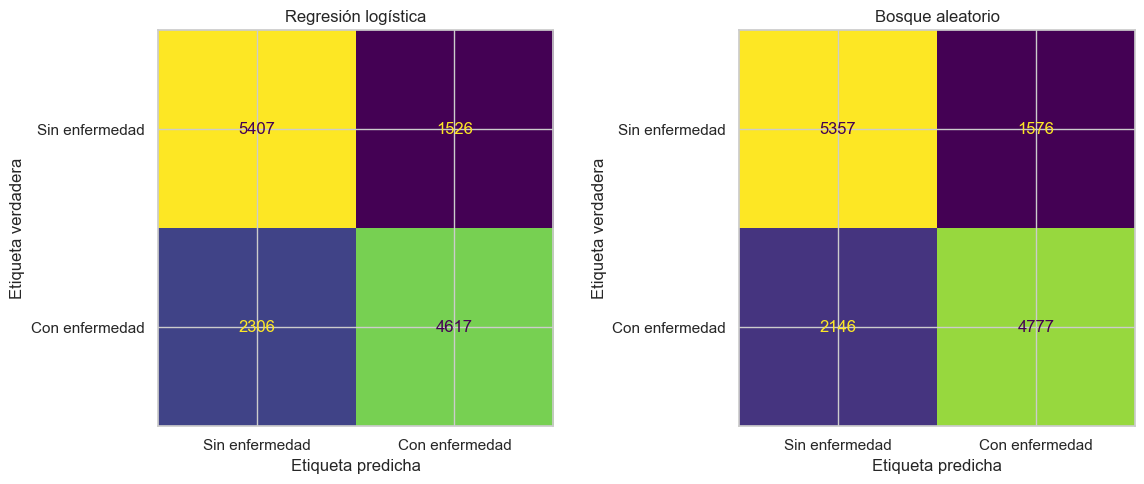

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_log = confusion_matrix(y_test, log_test_pred)
cm_rf = confusion_matrix(y_test, rf_test_pred)

display_labels = category_labels["cardio"]
plots = [(cm_log, "Regresión logística"), (cm_rf, "Bosque aleatorio")]

for ax, (cm, title) in zip(axes, plots):
    ConfusionMatrixDisplay(cm, display_labels=display_labels).plot(ax=ax, colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("Etiqueta predicha")
    ax.set_ylabel("Etiqueta verdadera")

plt.tight_layout()
plt.show()

###### Análisis

Ambos modelos muestran un desempeño similar, con el _Random Forest_ obteniendo métricas ligeramente superiores en ambos casos. La diferencia más notable está en el _recall_ para la clase 1 (enfermedad cardiovascular), donde el _Random Forest_ ($0.6900$) supera a la regresión logística ($0.6669$), lo que significa que detecta más casos positivos reales.

Sin embargo, ambos modelos tienen un _recall_ relativamente bajo para la clase 1 (alrededor del 67-69%), lo que implica que aproximadamente 1 de cada 3 pacientes con enfermedad cardiovascular no es detectado por los modelos (falsos negativos). Esto es problemático en un contexto médico, ya que no detectar una enfermedad cardiovascular puede tener consecuencias graves para el paciente.

###### Recomendación

Se recomienda utilizar el modelo **Random Forest** con los siguientes hiperparámetros:
- `n_estimators`: $200$
- `max_depth`: $20$  
- `min_samples_leaf`: $10$
- `class_weight="balanced_subsample"`
- `random_state=42`

###### Justificación

1. El _Random Forest_ tiene mejor _accuracy_ ($0.7314$ vs $0.7234$) y F1-score ($0.7196$ vs $0.7067$).
2. Más importante aún, tiene mejor _recall_ para la clase 1 ($0.6900$ vs $0.6669$), lo que significa que detecta más casos de enfermedad cardiovascular.
3. En un contexto médico, es preferible minimizar los falsos negativos (pacientes enfermos clasificados como sanos), y el _Random Forest_ tiene un mejor desempeño en este aspecto.

###### Consideraciones adicionales

Aunque el _Random Forest_ es la mejor opción entre los dos modelos probados, el _recall_ del $0.6900$ para casos positivos sigue siendo preocupante. En un sistema de diagnóstico real, este modelo debería usarse como herramienta de apoyo complementaria al criterio médico profesional, no como único método de diagnóstico. Se podría considerar ajustar el _threshold_ de decisión para aumentar el _recall_ (detectar más casos positivos) a costa de una menor _precision_ (más falsos positivos), lo cual es más aceptable en medicina preventiva.